# Process 4T1 colony lineage data

## Purpose

This notebook processes data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublets. It also processes target site spots, filtering out dim spots, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import treedata as td
import numpy as np
import multiprocessing as mp
import geopandas as gpd
from sklearn.cluster import DBSCAN, SpectralClustering
from pathlib import Path
import petracer
import sys
np.random.seed(42)
import pycea as py

from petracer.config import sequential_cmap, site_names
from petracer.clones import call_clones
from petracer.tree import alleles_to_characters, reconstruct_tree
site_names = list(site_names.keys())

base_path, data_path, plot_path, results_path = petracer.config.get_paths("colony_tracing")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

Specify samples and names

In [785]:
samples = {"colony":Path("/lab/weissman_imaging/4T1/240517_colony/")}

Cells

In [786]:
cells = []
for sample, path in samples.items():
    sample_cells = pd.read_csv(path / "polygons_metadata.csv")
    sample_cells["sample"] = sample
    sample_cells["cellBC"] = (sample + "-" + sample_cells["cell"].astype(str).values)
    cells.append(sample_cells.drop(columns=["cell"]))
cells = pd.concat(cells, ignore_index=True)
cells.index = cells.cellBC.values
adata = ad.AnnData(obs=cells)
adata.obs["type"] = "tracing"
adata.obs["type"] = pd.Categorical(adata.obs["type"], 
       categories=["tracing", "non-tracing", "doublet", "low_detection", "low_umi", "high_mito"])
adata.obsm["spatial"] = cells[["centroid_x", "centroid_y"]].values

Target site

In [787]:
alleles = []
for sample, path in samples.items():
    sample_alleles =  pd.read_csv(f"{path}/decoded_spots.csv",keep_default_na=False,index_col=0)
    sample_alleles["sample"] = sample
    sample_alleles["cellBC"] = (sample + "-" + sample_alleles["cell"].astype(str).values)
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(cells.cellBC)]
alleles.rename(columns={"intBC":"intID"},inplace=True)

/tmp/ipykernel_3634296/2758917492.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_alleles =  pd.read_csv(f"{path}/decoded_spots.csv",keep_default_na=False,index_col=0)


## Imaging statistics

Cells per sample

<Axes: xlabel='sample', ylabel='count'>

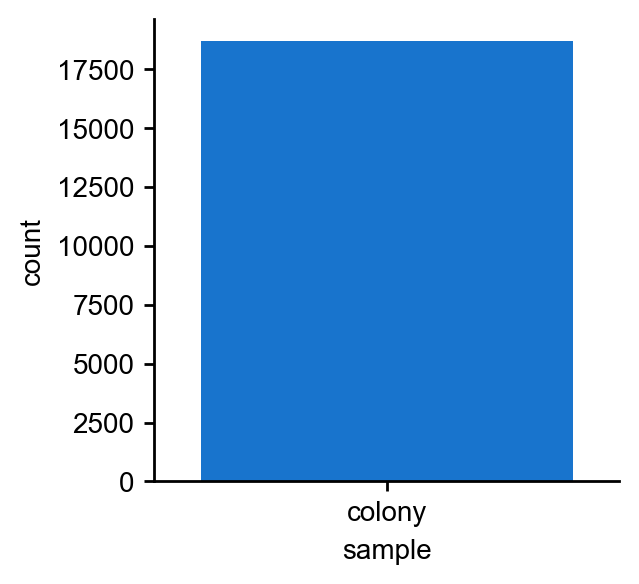

In [788]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)

intBC intensity vs distance

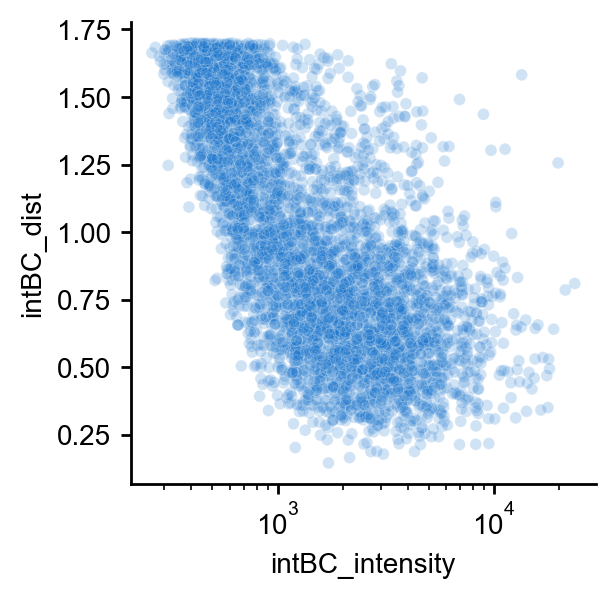

In [188]:
sns.scatterplot(data =alleles.sample(5000), x = "intBC_intensity", y = "intBC_dist",
                hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")

Alleles per cell

<Axes: xlabel='n_spots', ylabel='Count'>

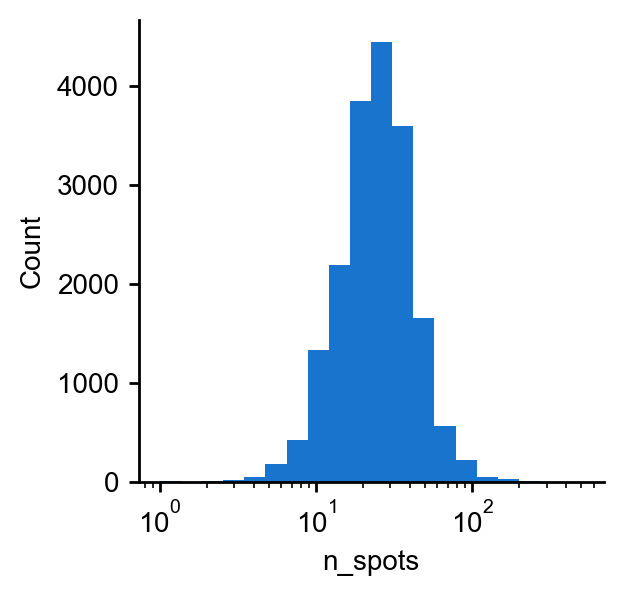

In [189]:
sns.histplot(data = alleles.groupby(["sample","cellBC"]).size().reset_index(name = "n_spots"), 
            x = "n_spots",hue = "sample",legend=False,multiple="stack",linewidth=0,bins = 20,alpha = 1,log_scale=True)

## Filter target site spots

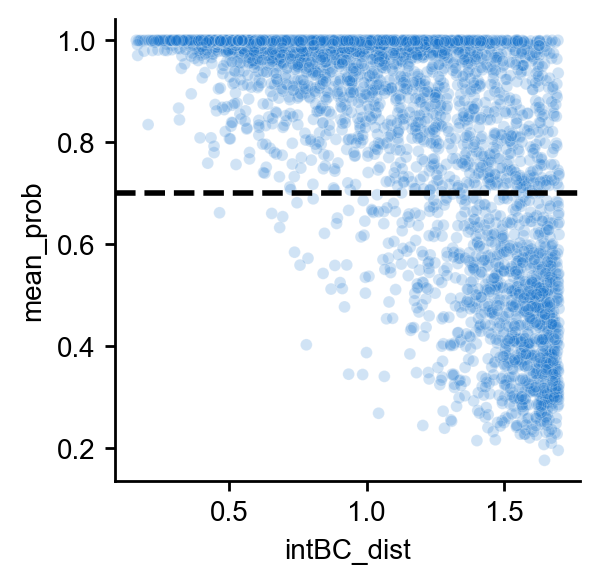

In [190]:
min_avg_prob = 0.7
alleles["mean_prob"] = alleles[["EMX1_prob","HEK3_prob","RNF2_prob"]].mean(axis=1)
filtered_alleles = alleles.query("mean_prob > @min_avg_prob").copy()
sns.scatterplot(data = alleles.sample(5000), x = "intBC_dist", y = "mean_prob",
                hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.axhline(min_avg_prob, linestyle="--",color = "black")

## Identify colonies

Get spatial clusters with DBSCAN

In [191]:
adata.obs["cluster"] = DBSCAN(eps = 60).fit_predict(adata.obs[["centroid_x","centroid_y"]].values)

Remove small cluster and rename by size

In [192]:
colony_counts = adata.obs.query("cluster != -1").groupby(["sample","cluster"]).size().reset_index(name = "n").sort_values("n",ascending = False)
colony_counts["colony"] = (colony_counts.reset_index().index + 1).astype(str)
cluster_to_colony = colony_counts.query("n > 25").set_index(["cluster"])["colony"].to_dict()
adata.obs["colony"] = adata.obs["cluster"].map(cluster_to_colony)
adata.obs.drop(columns = ["cluster"],inplace = True)
filtered_alleles["colony"] = filtered_alleles["cellBC"].map(adata.obs["colony"])

Plot colonies

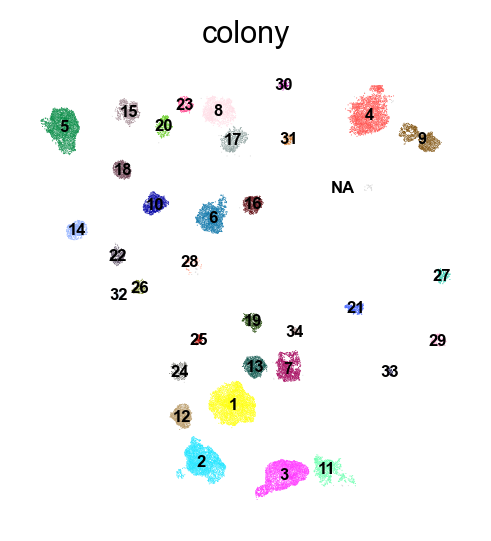

In [193]:
sc.pl.spatial(adata, color = "colony",legend_loc = "on data",spot_size=20,legend_fontsize = 6,frameon=False)

## Idenitfy clones


/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._figure = plt.figure(figsize=figsize)


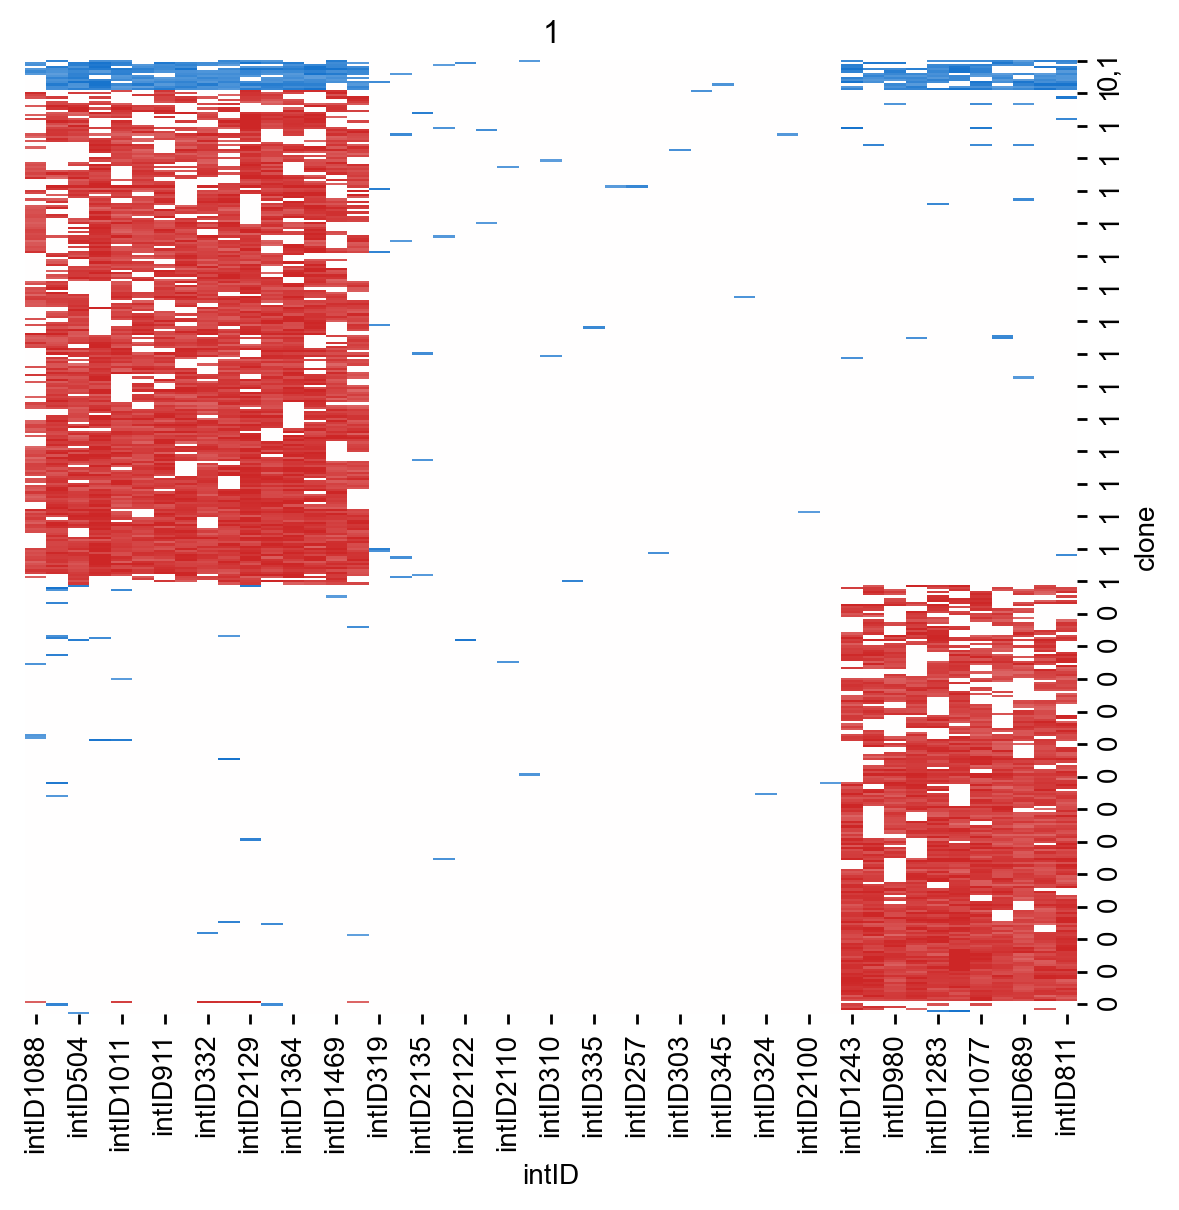

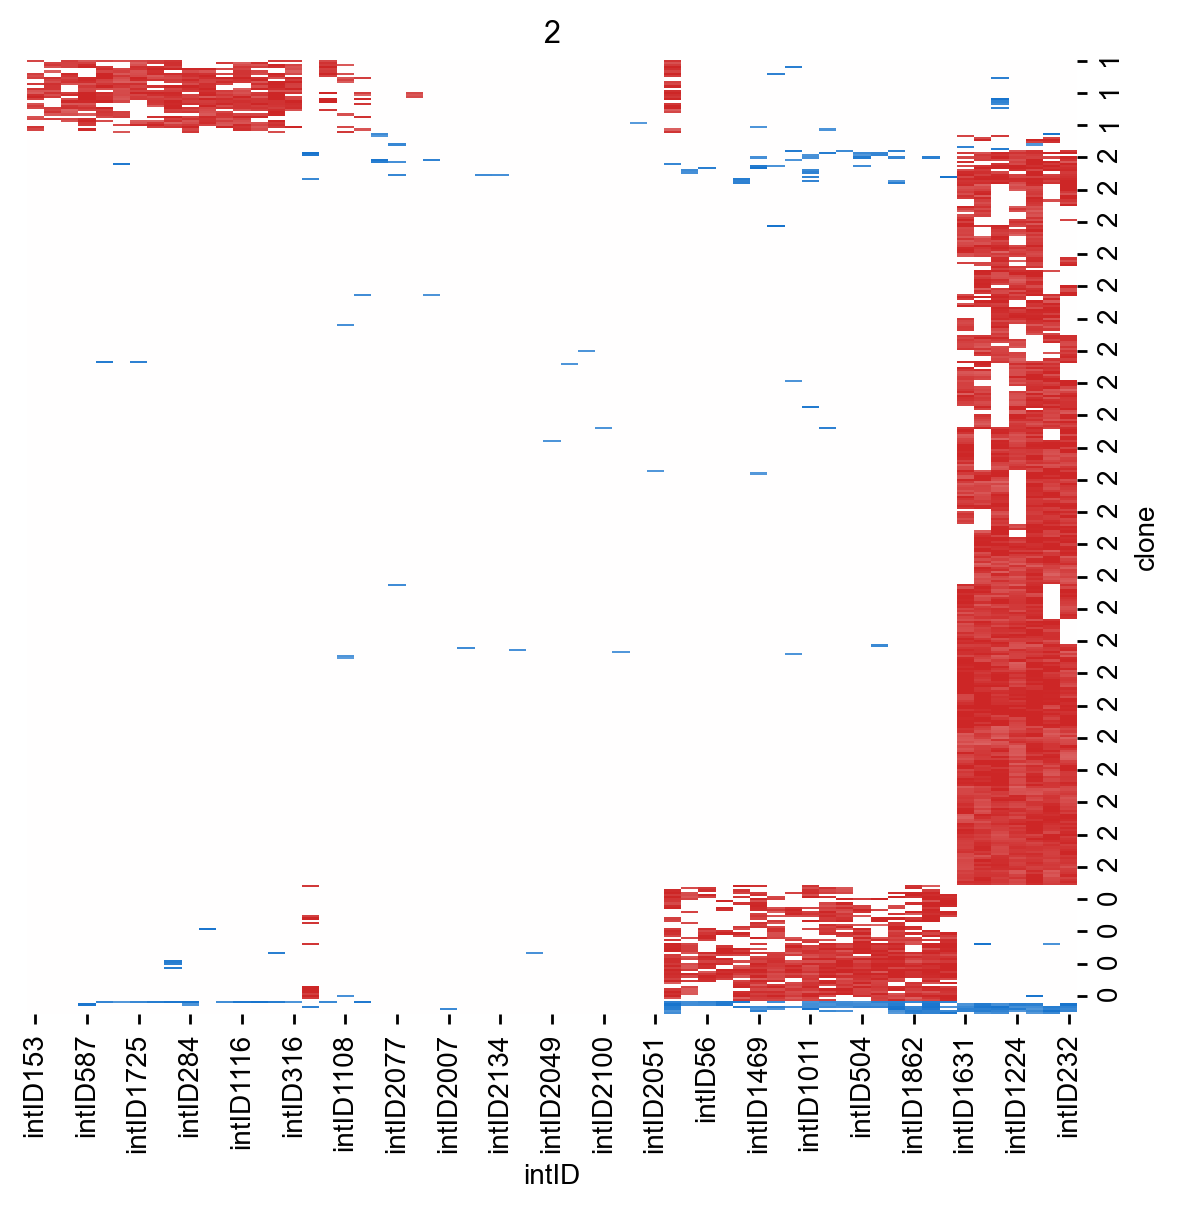

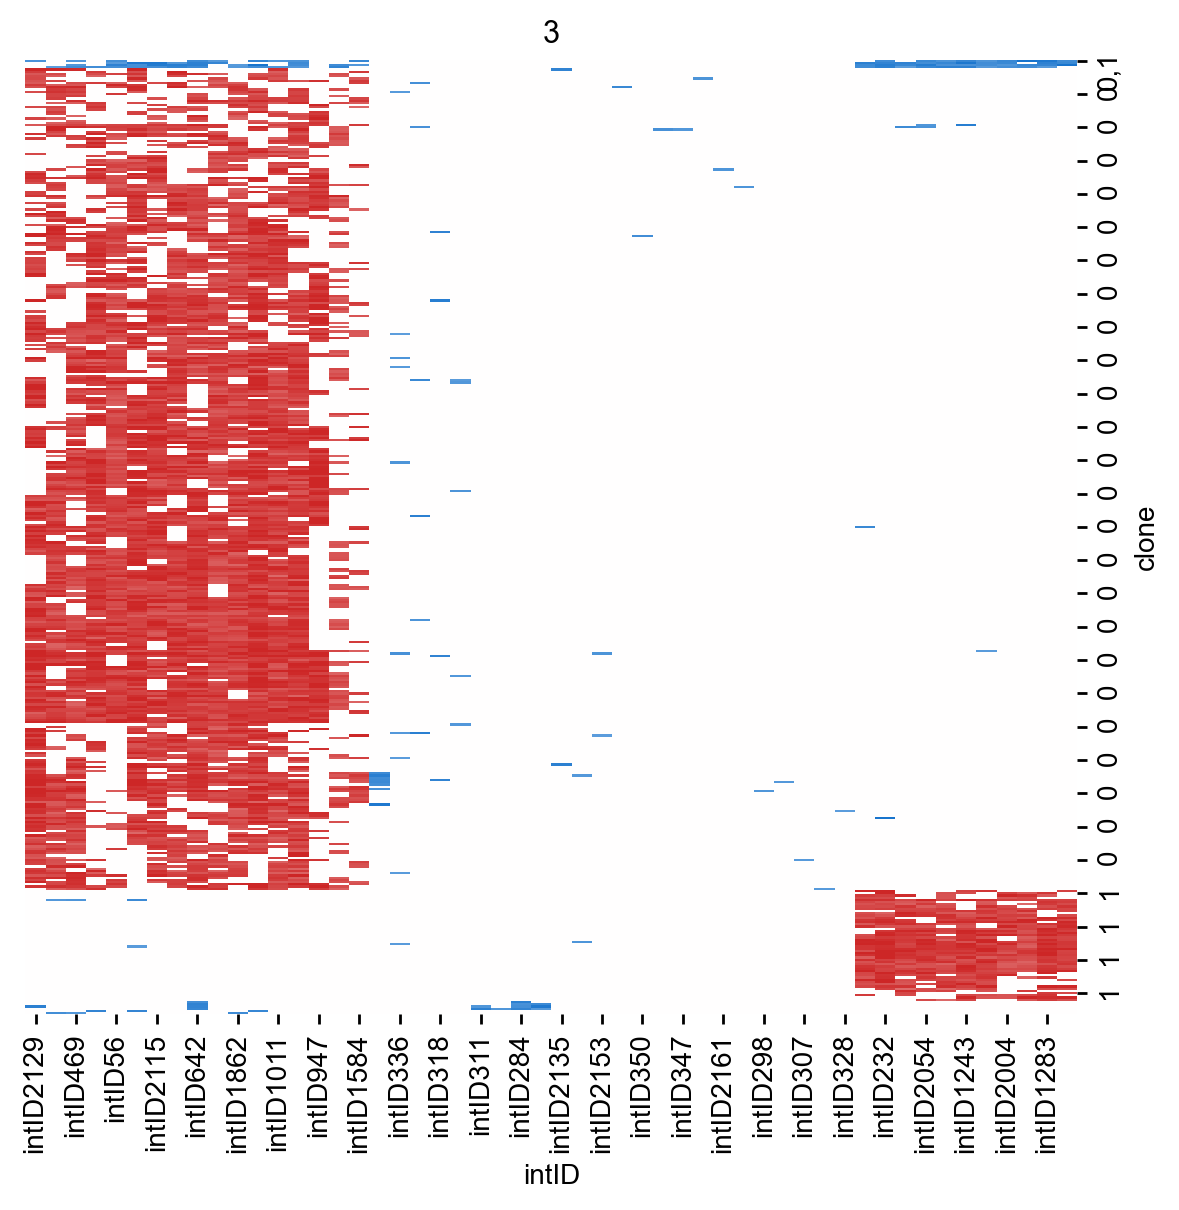

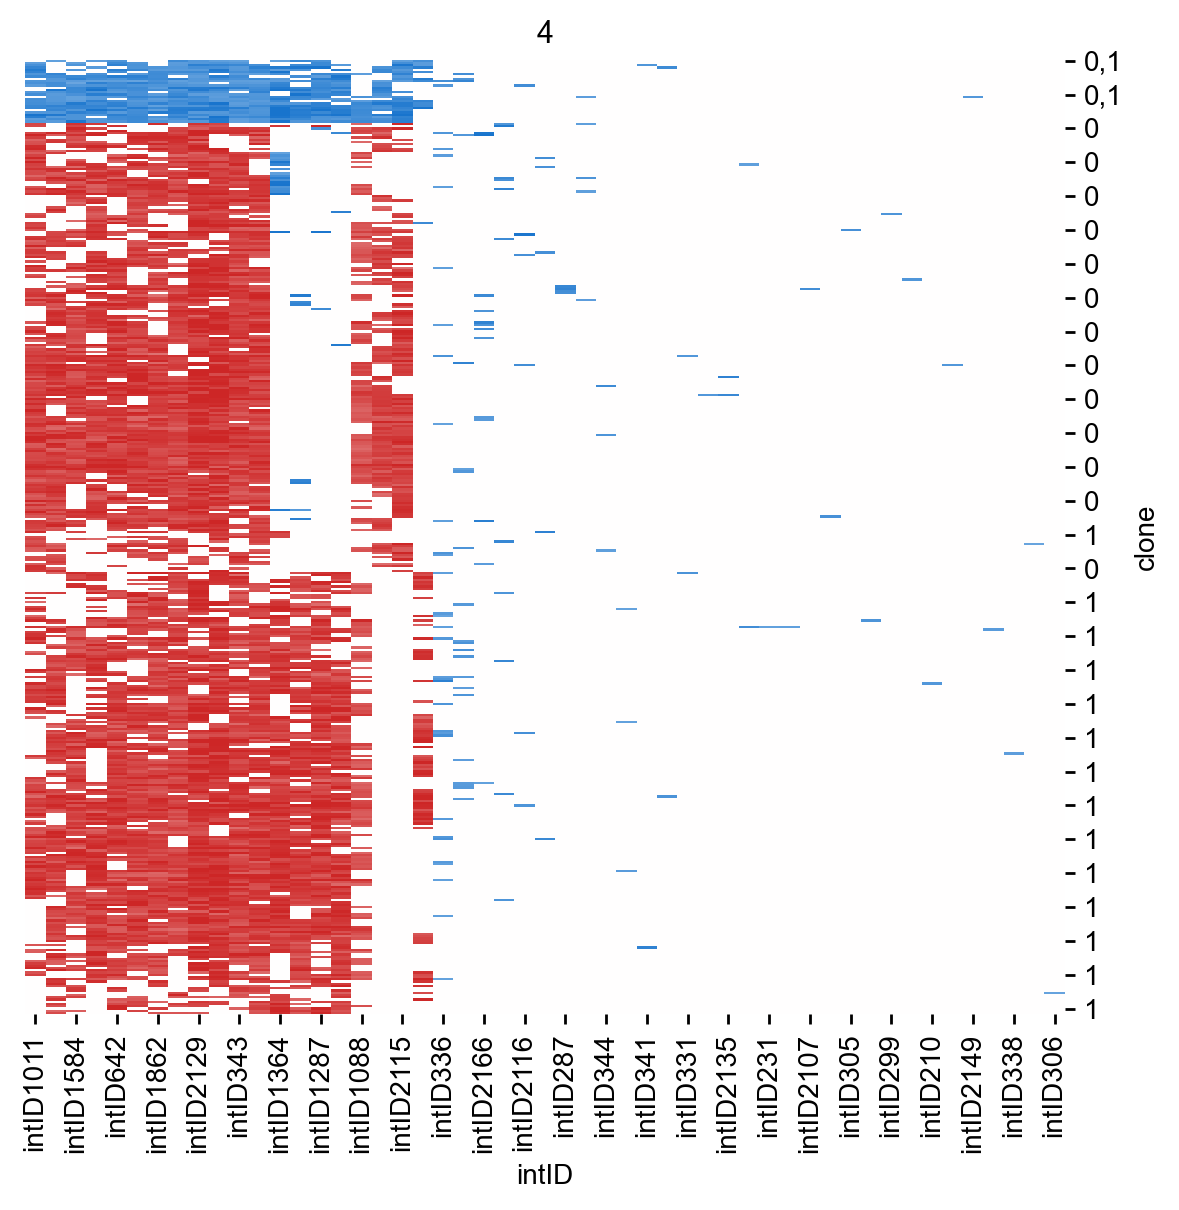

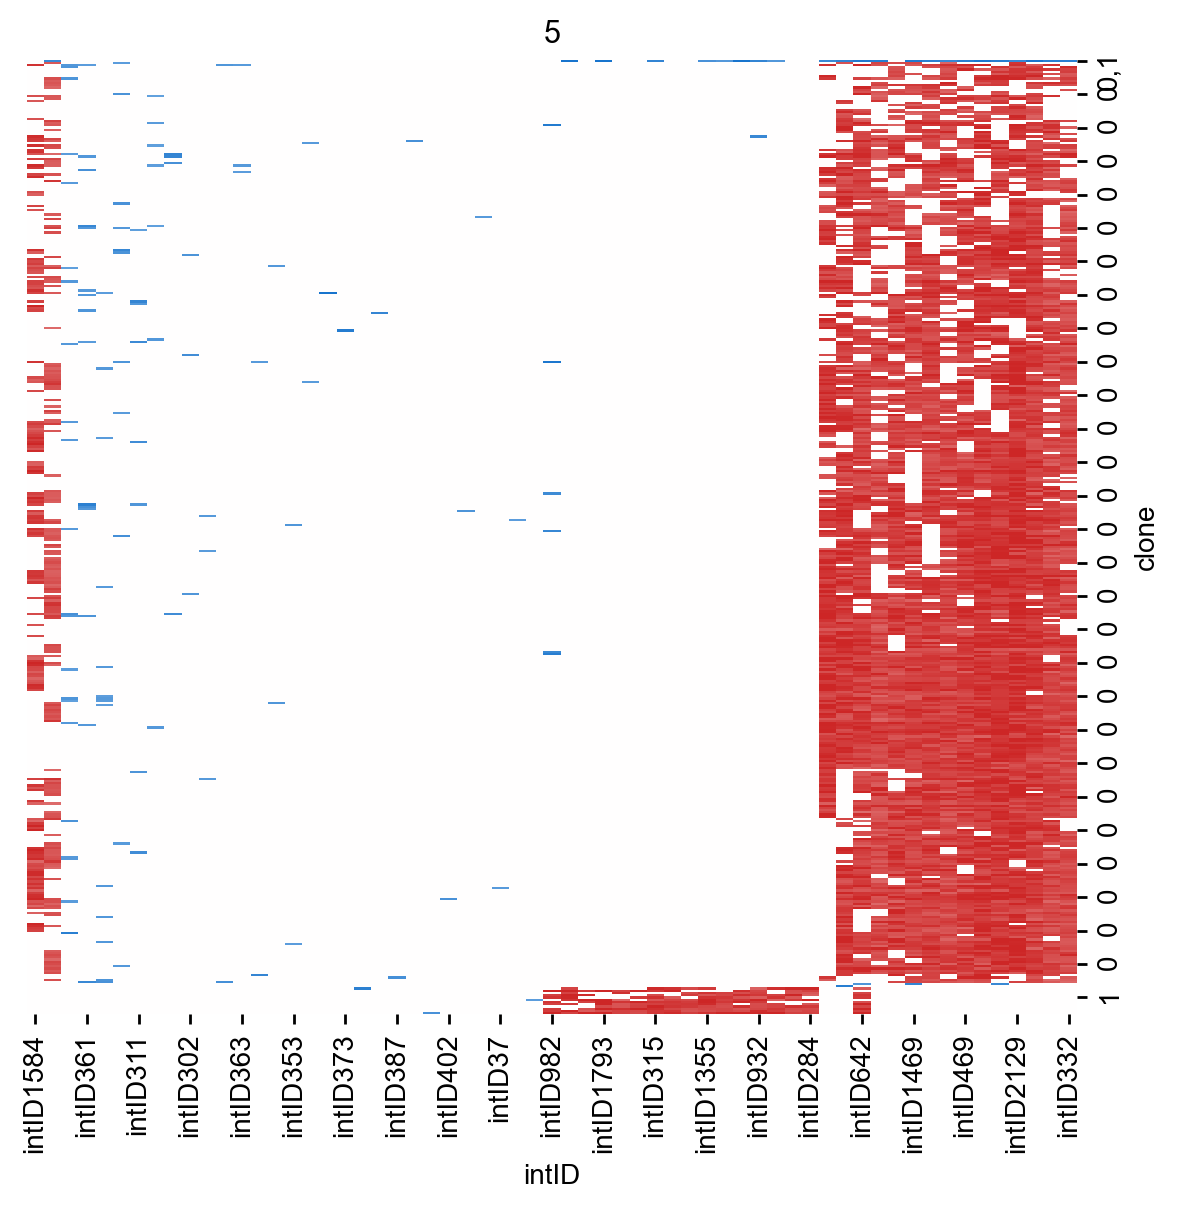

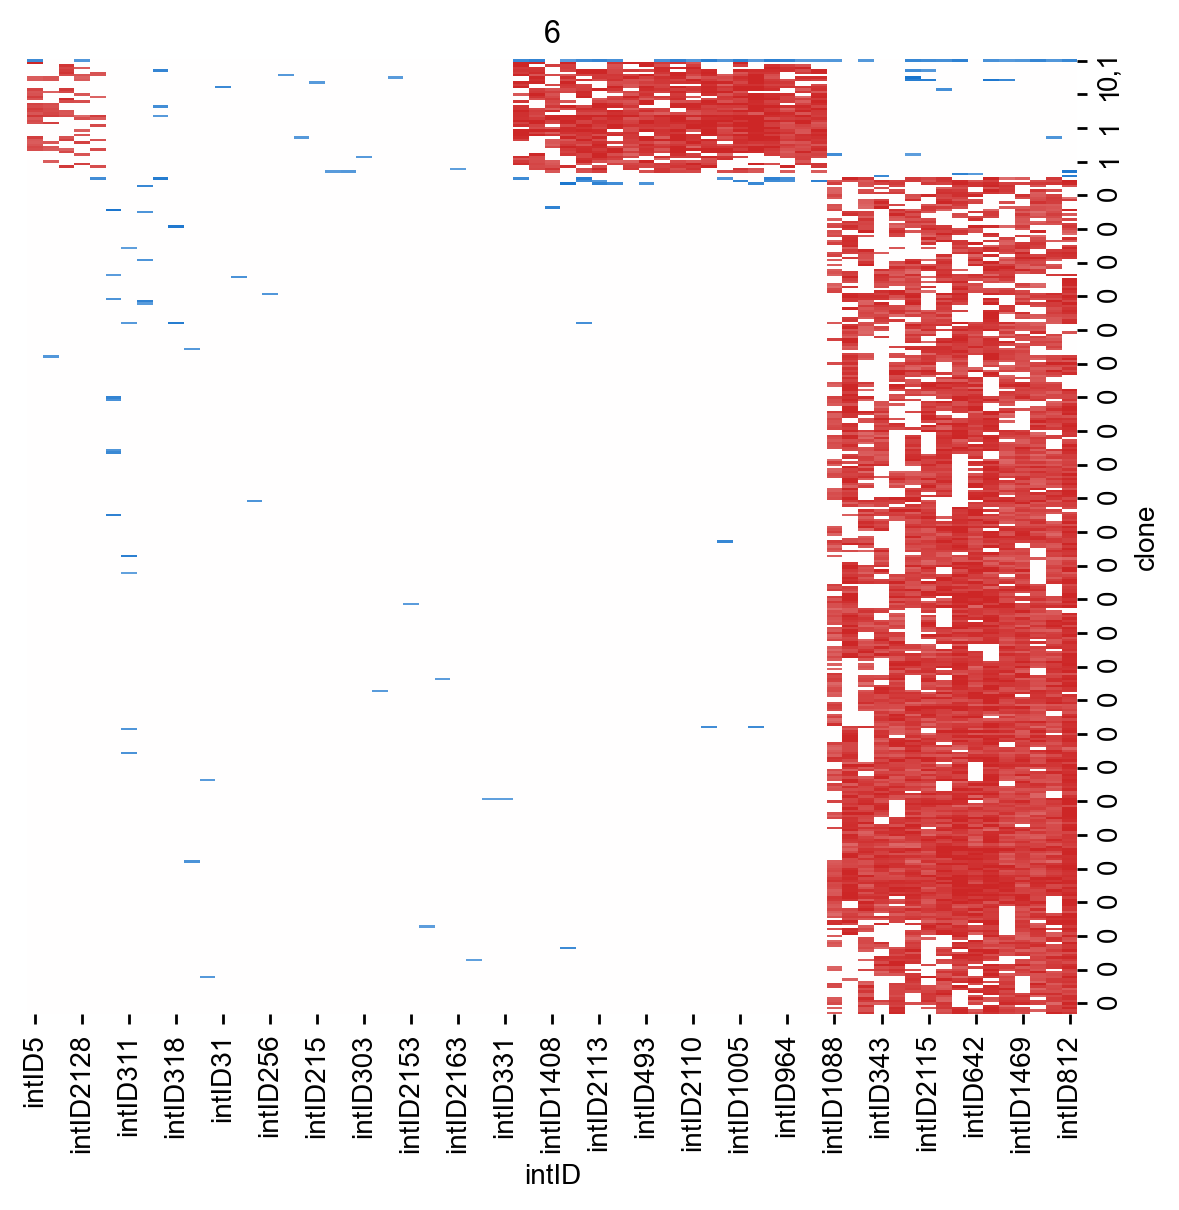

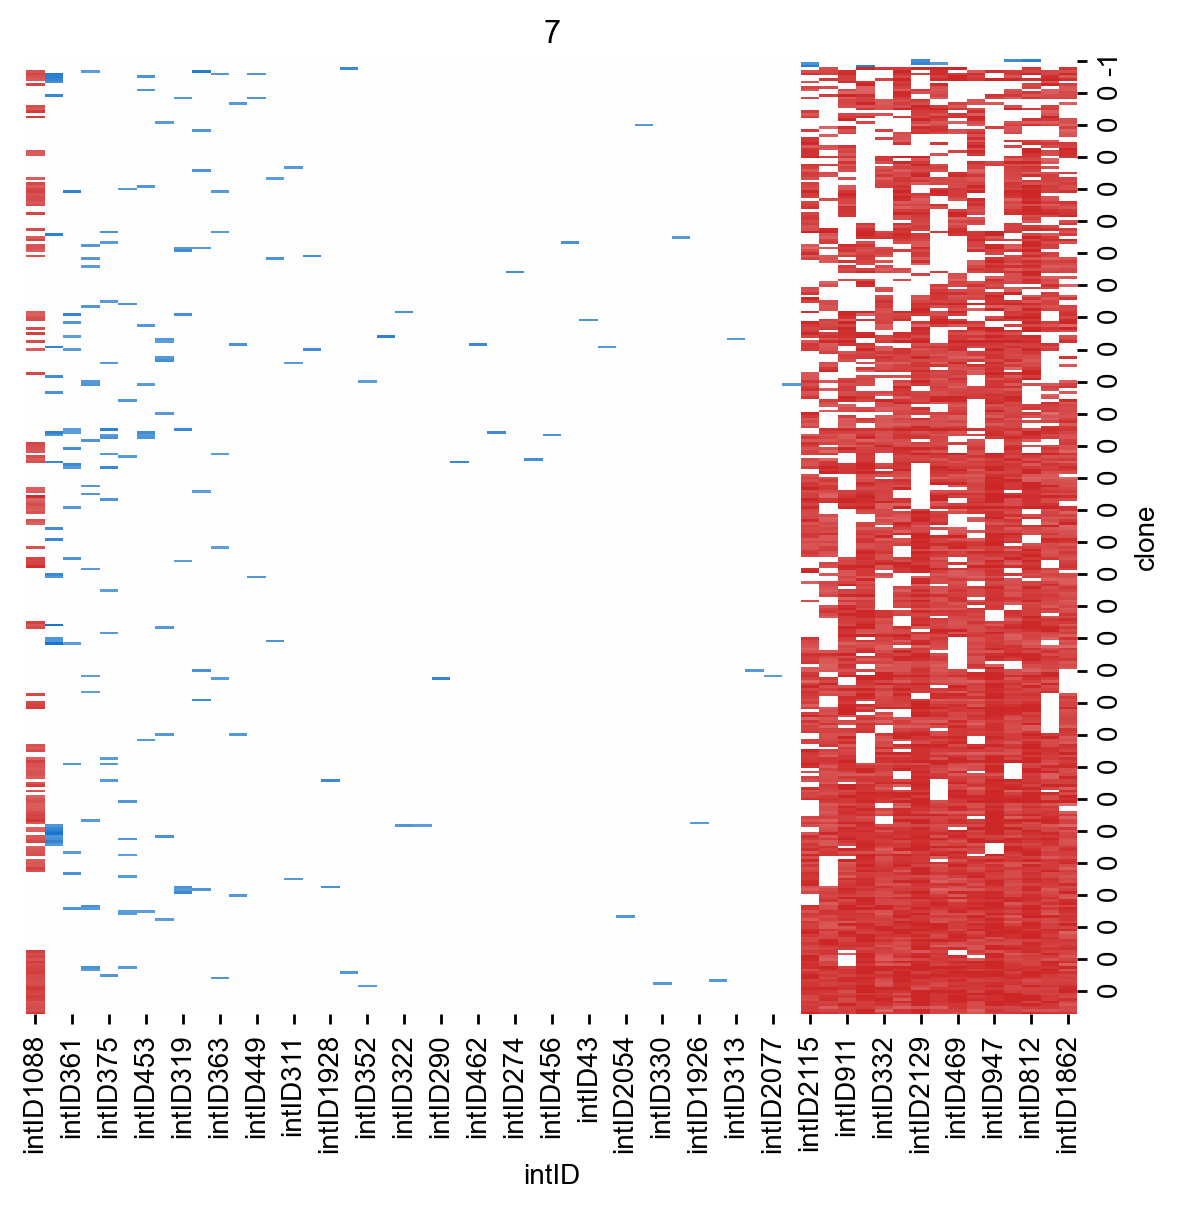

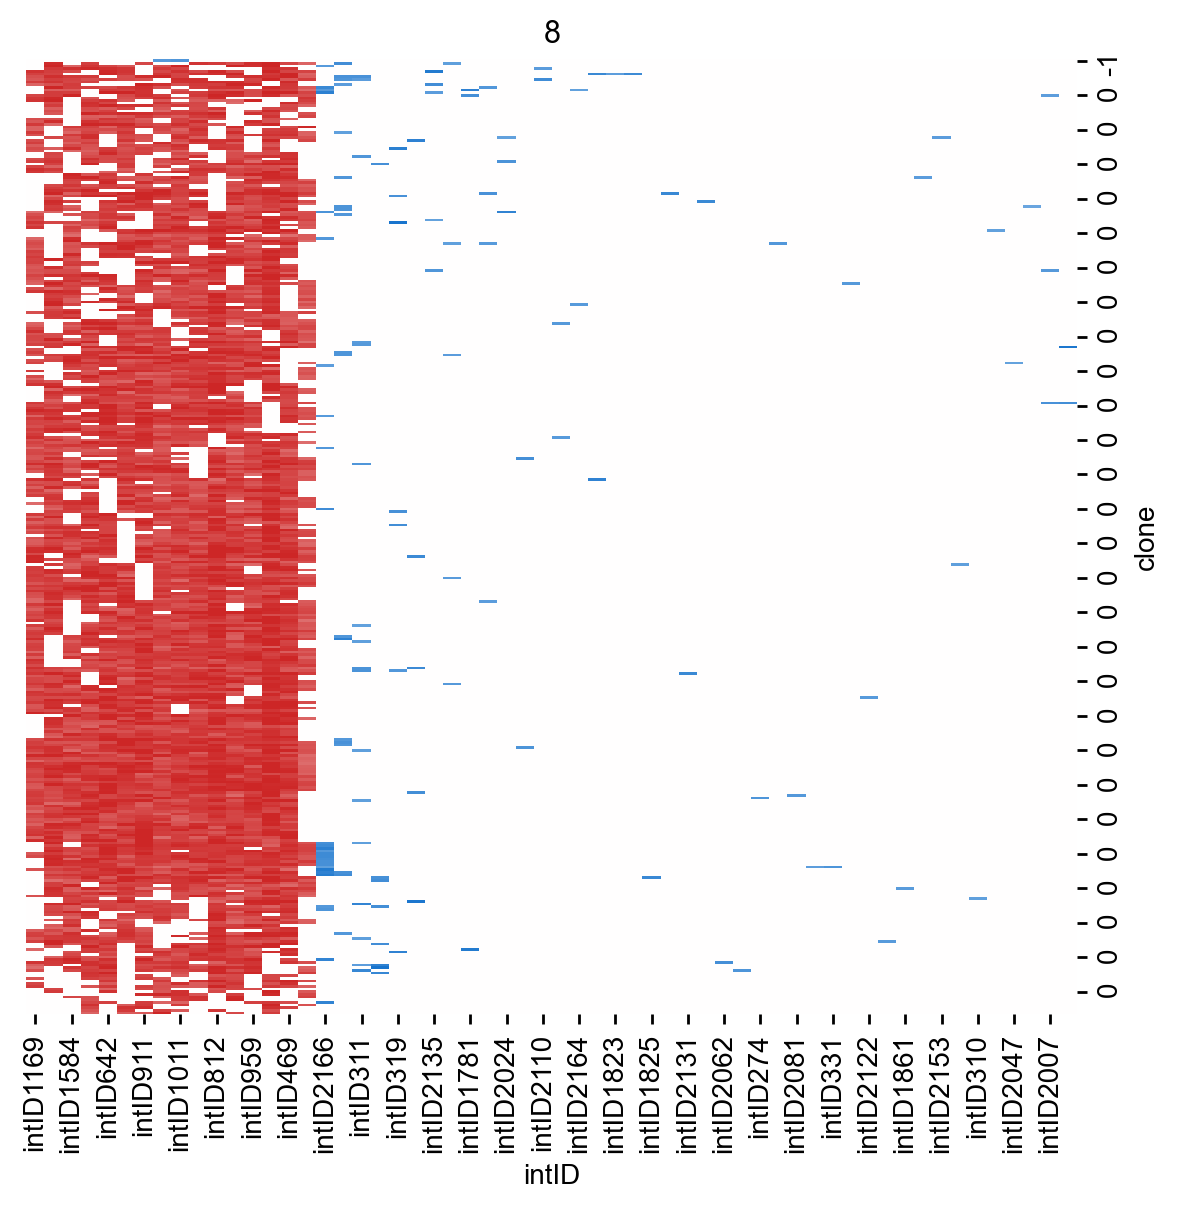

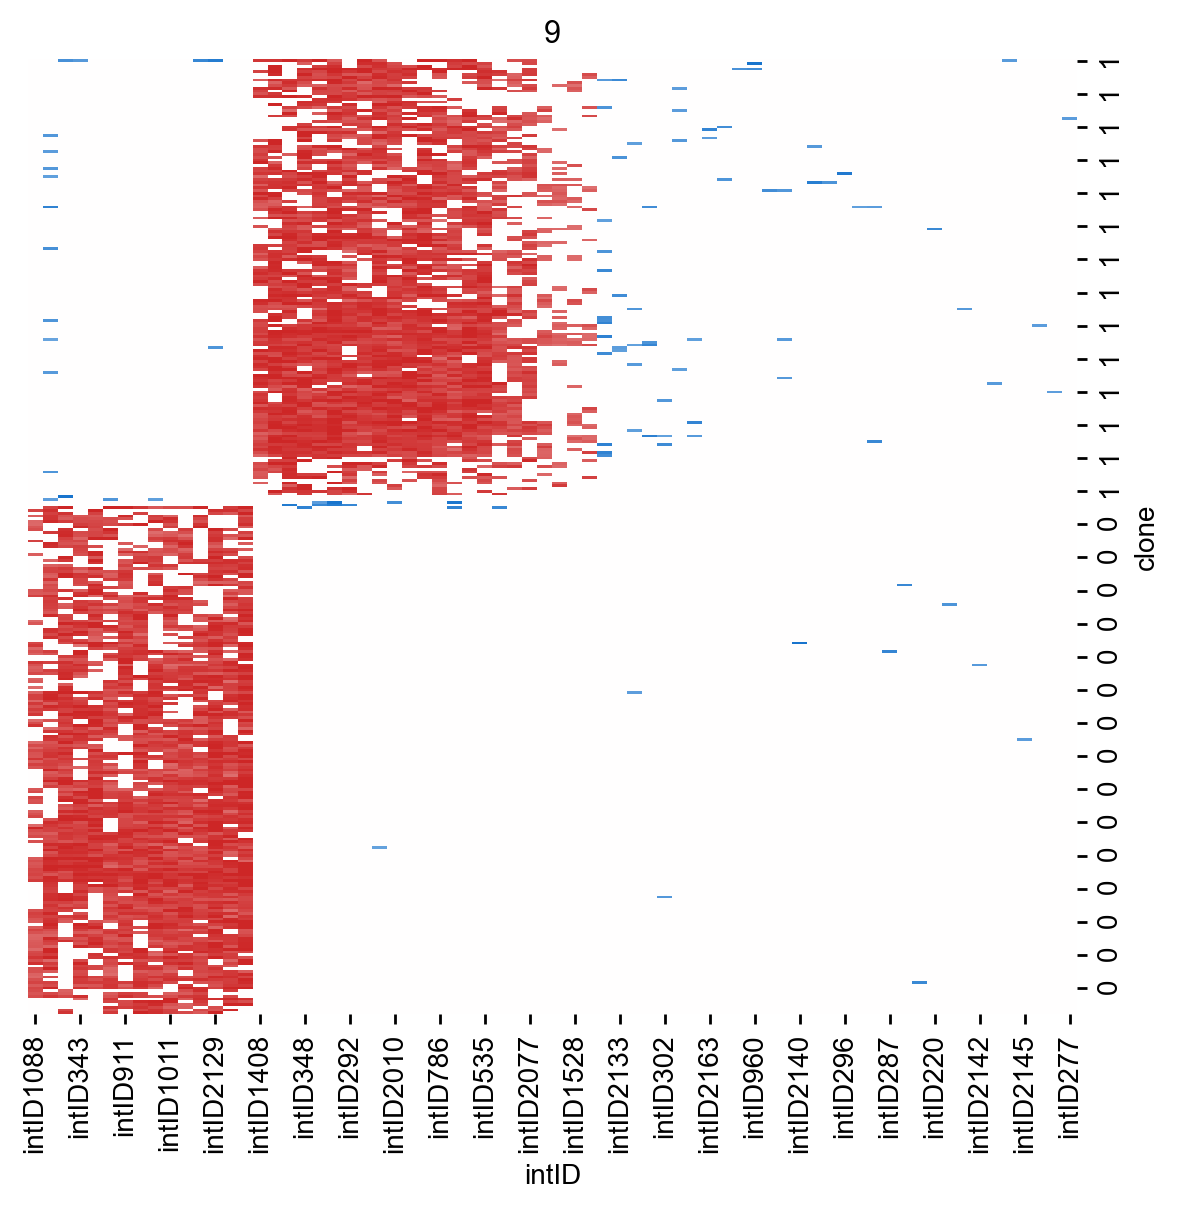

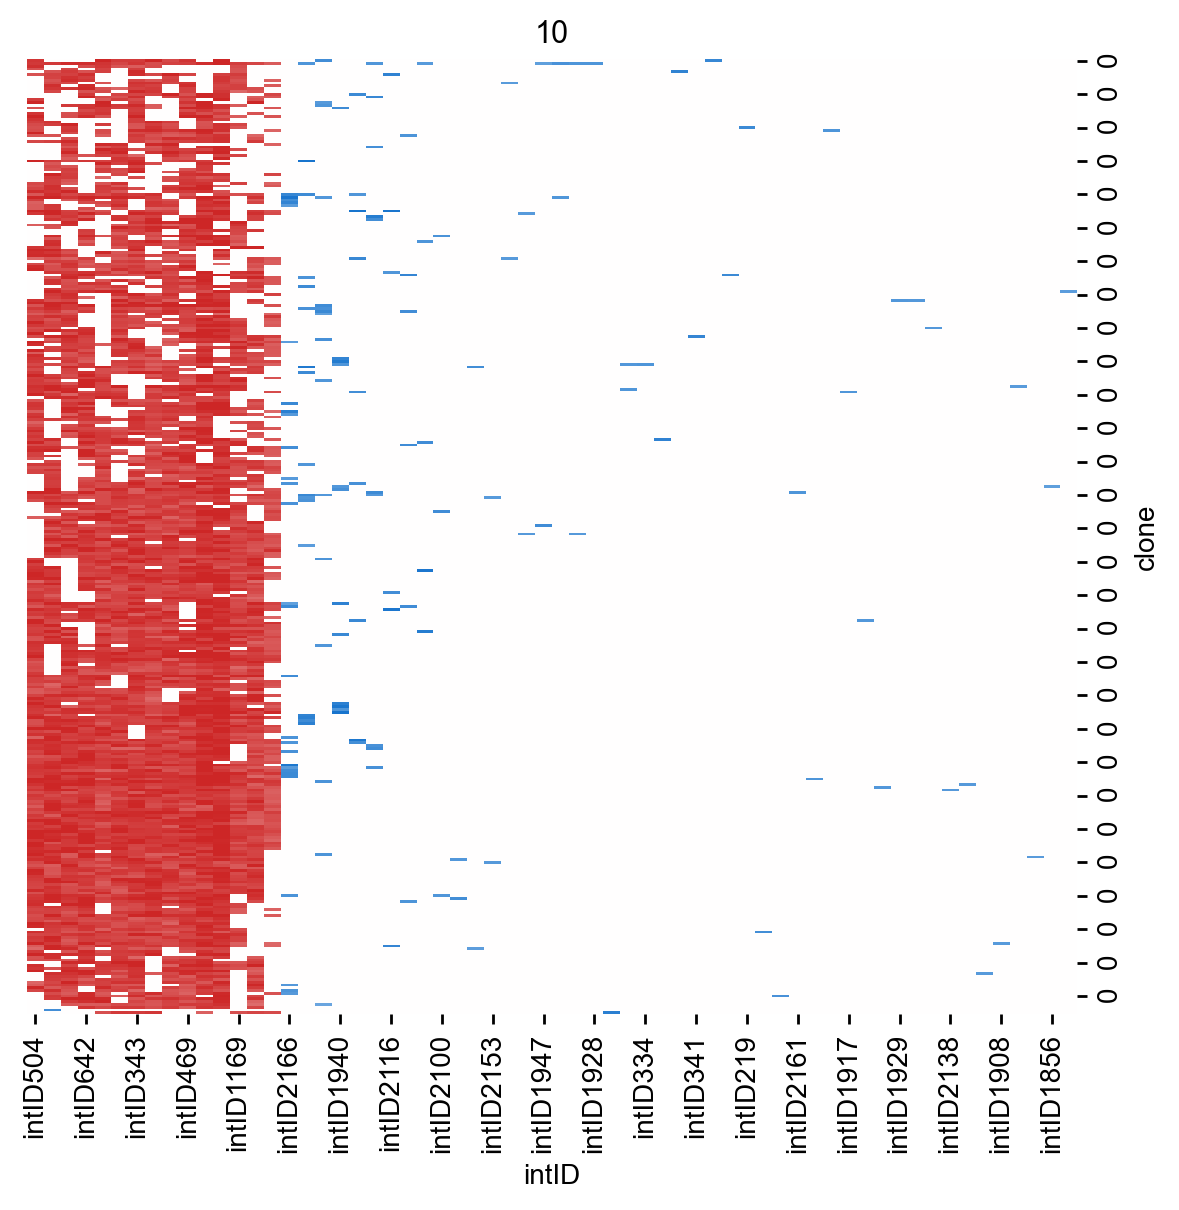

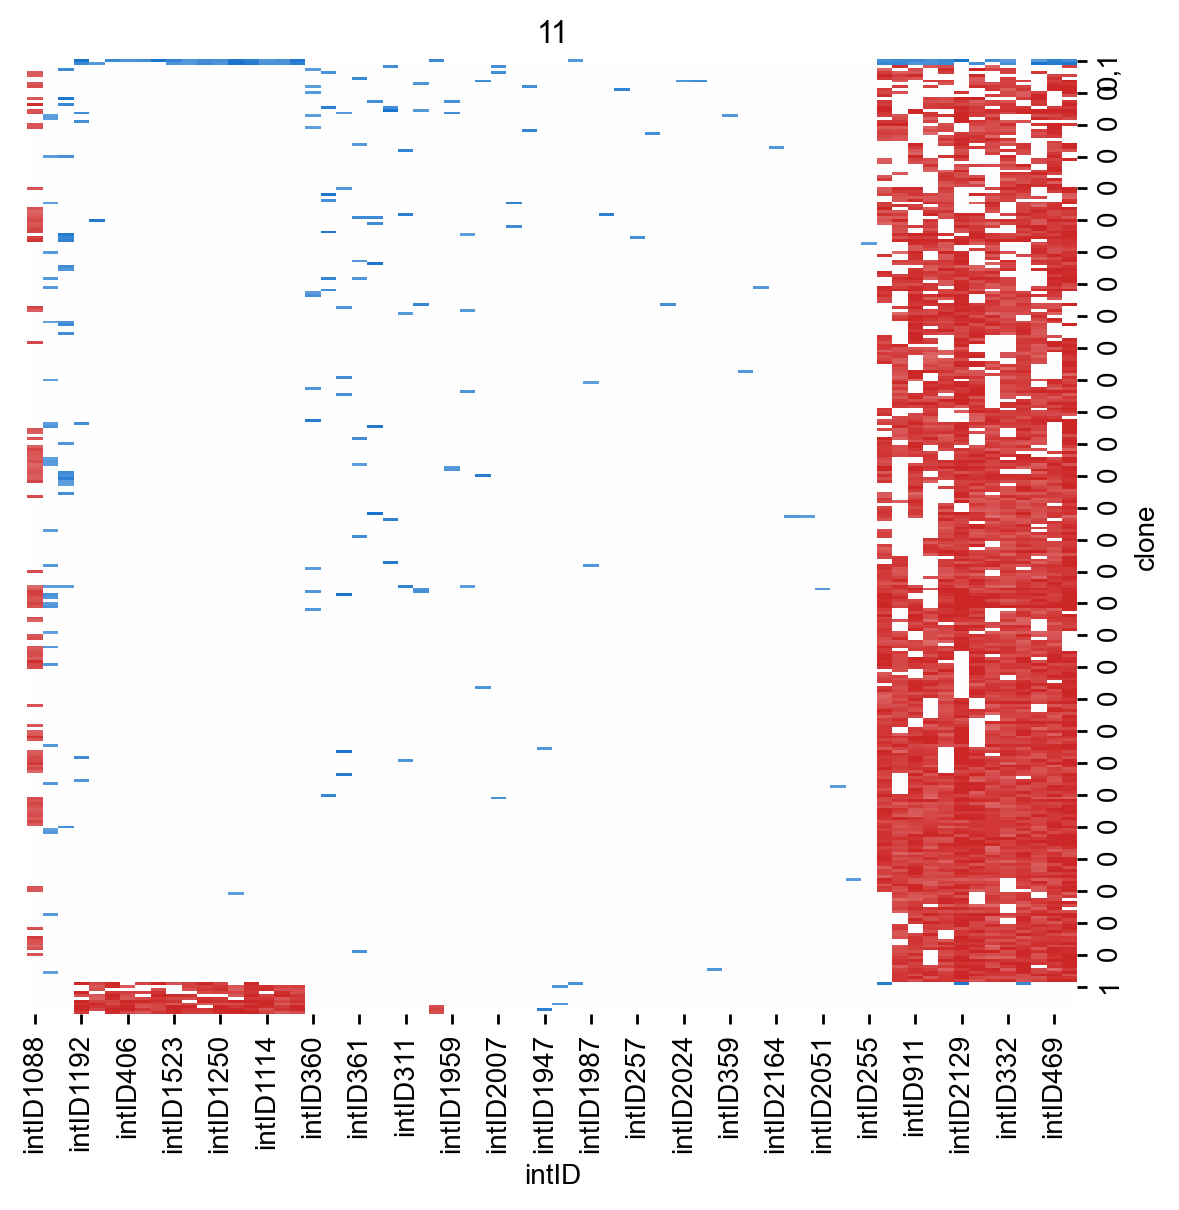

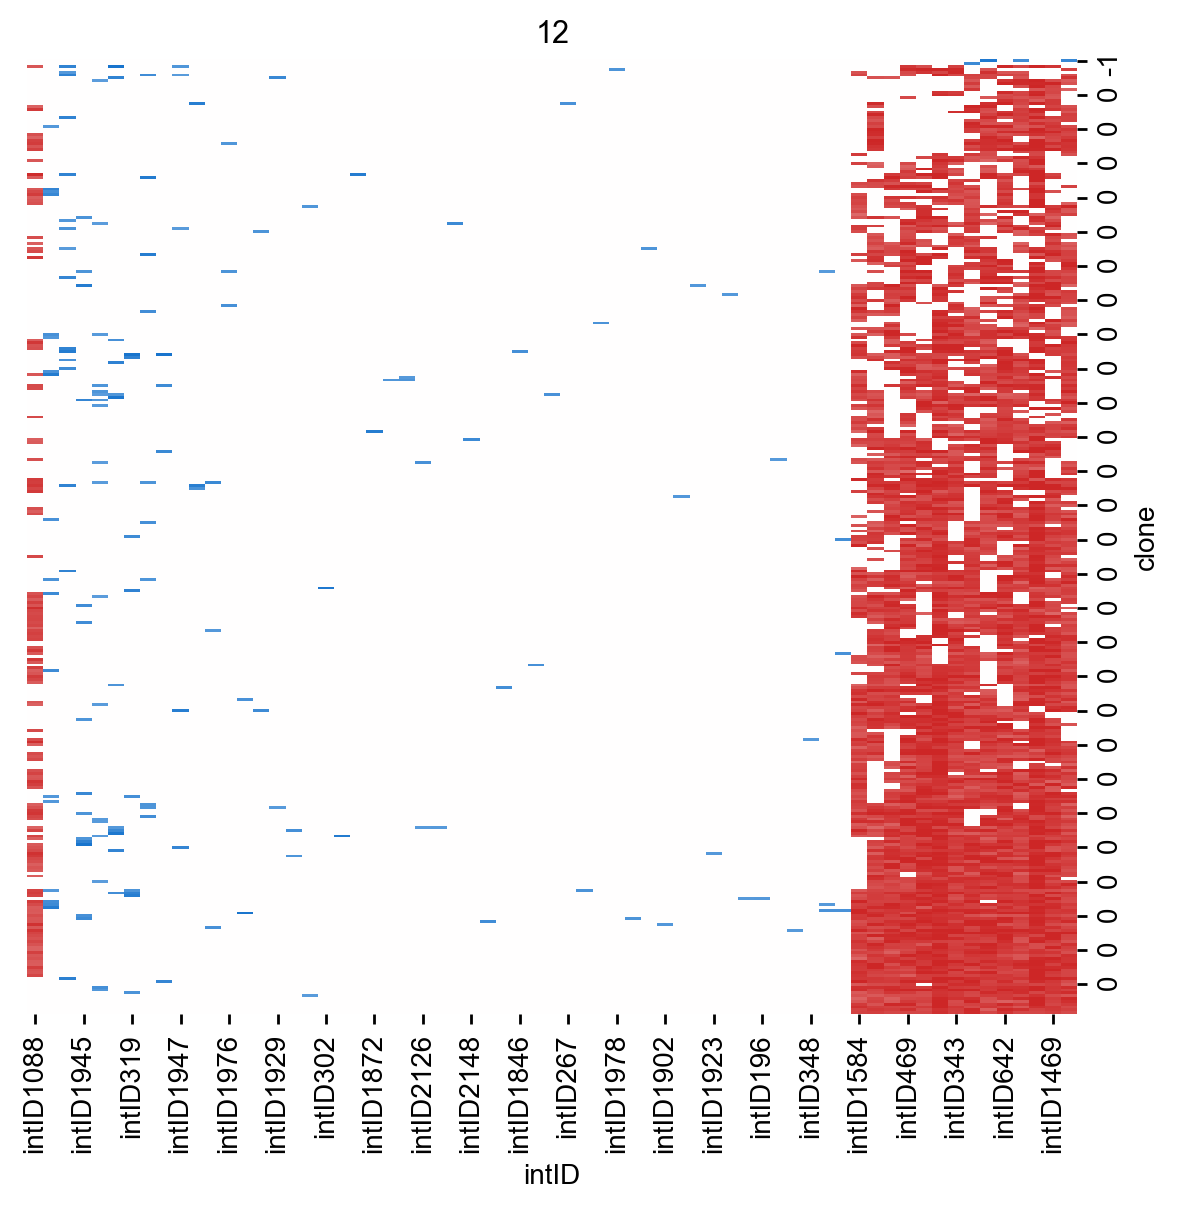

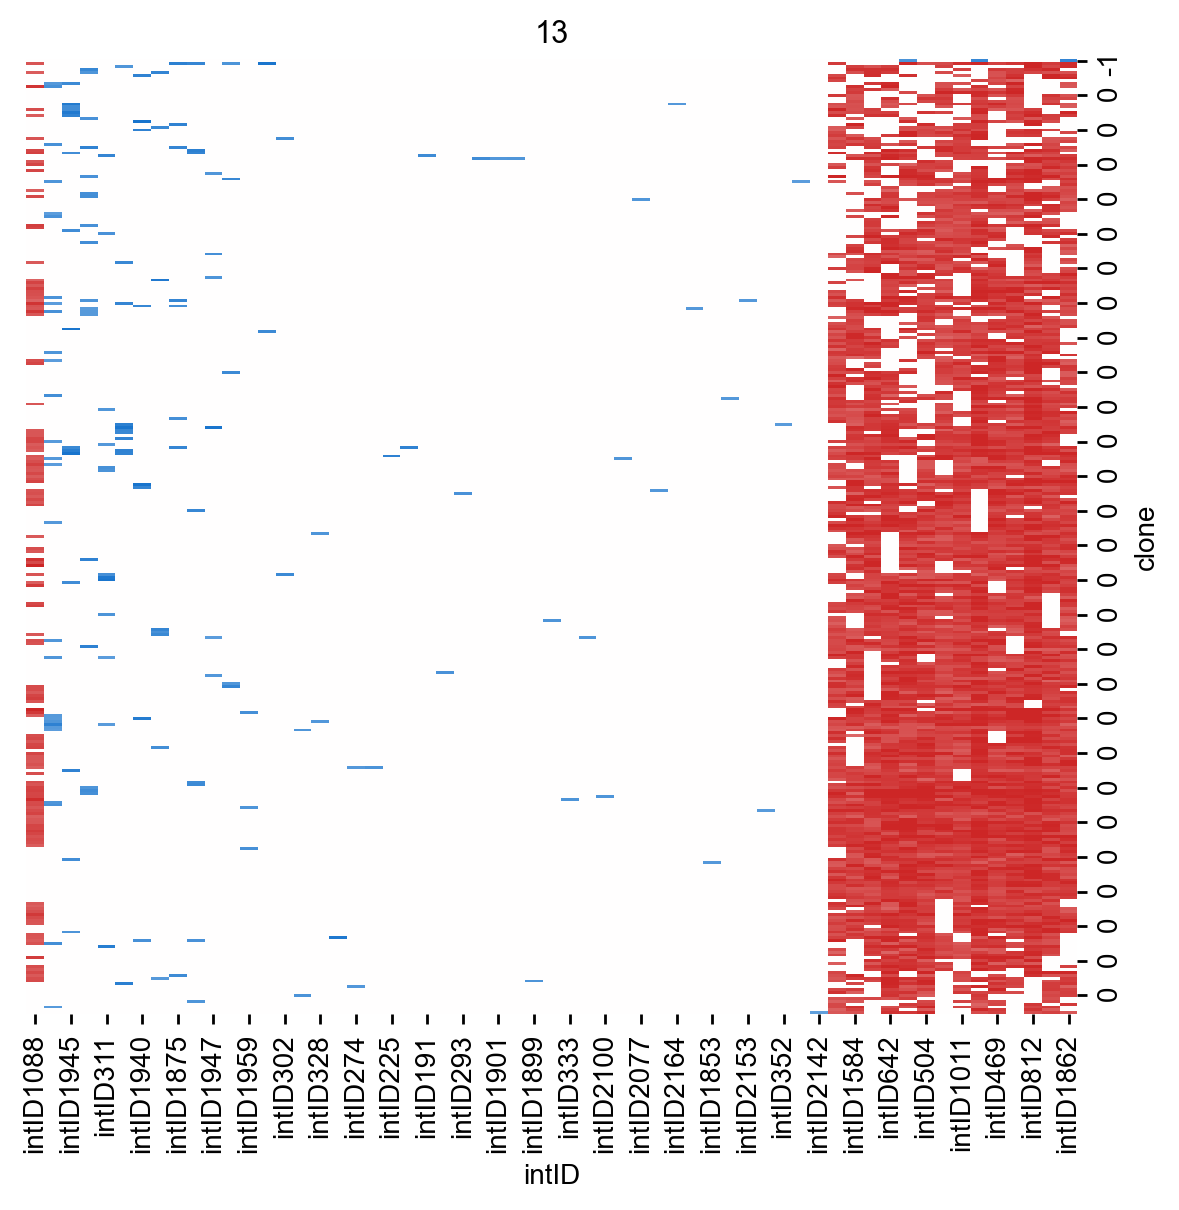

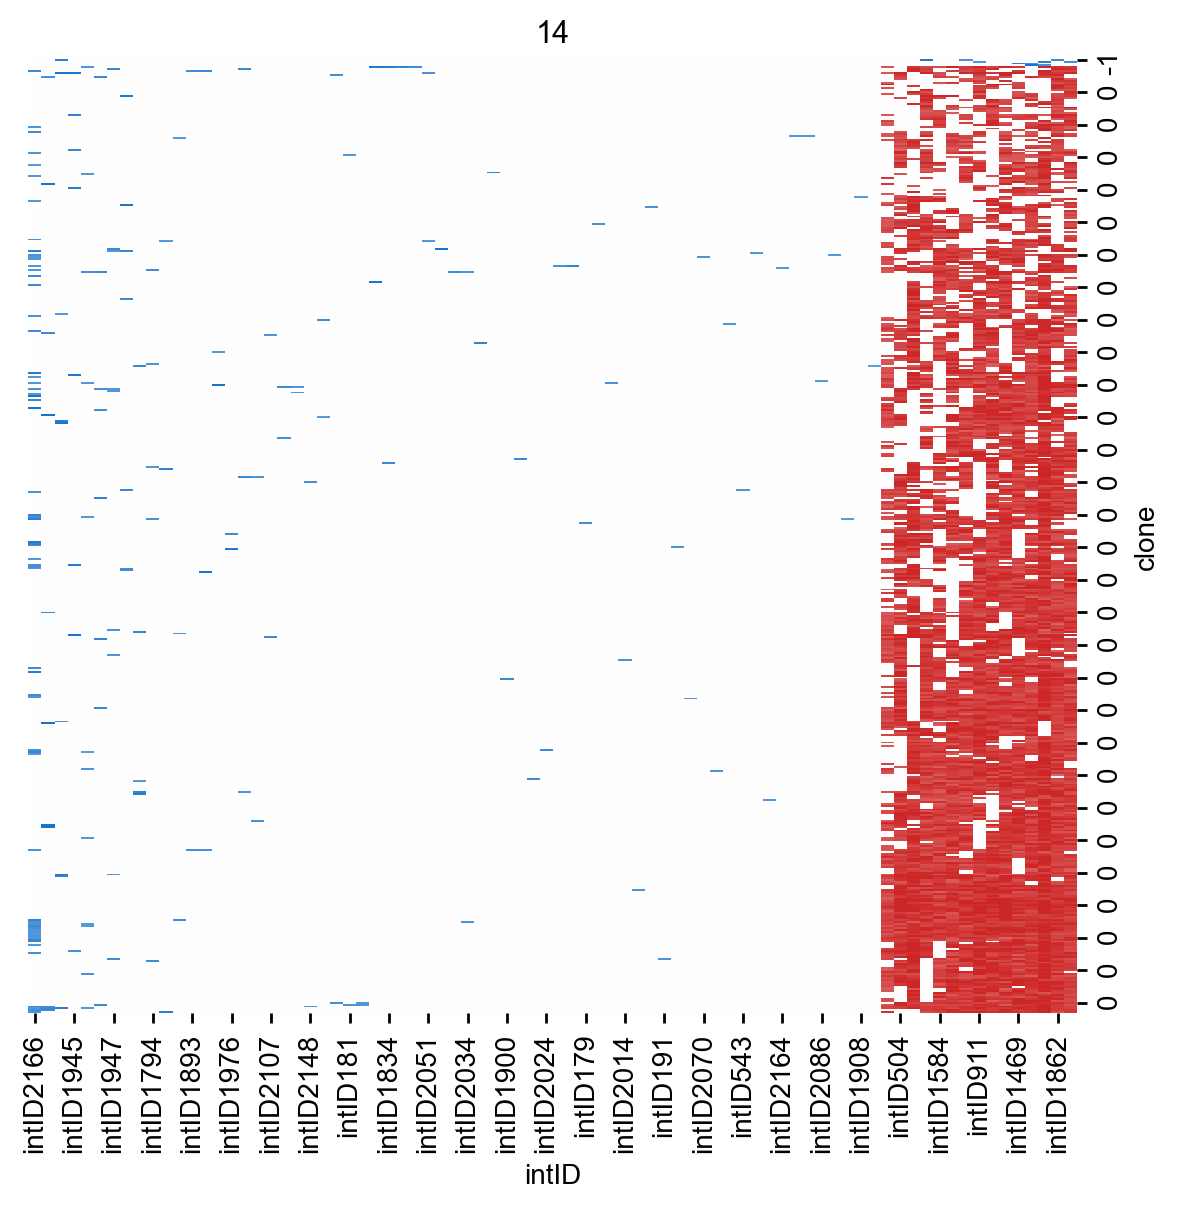

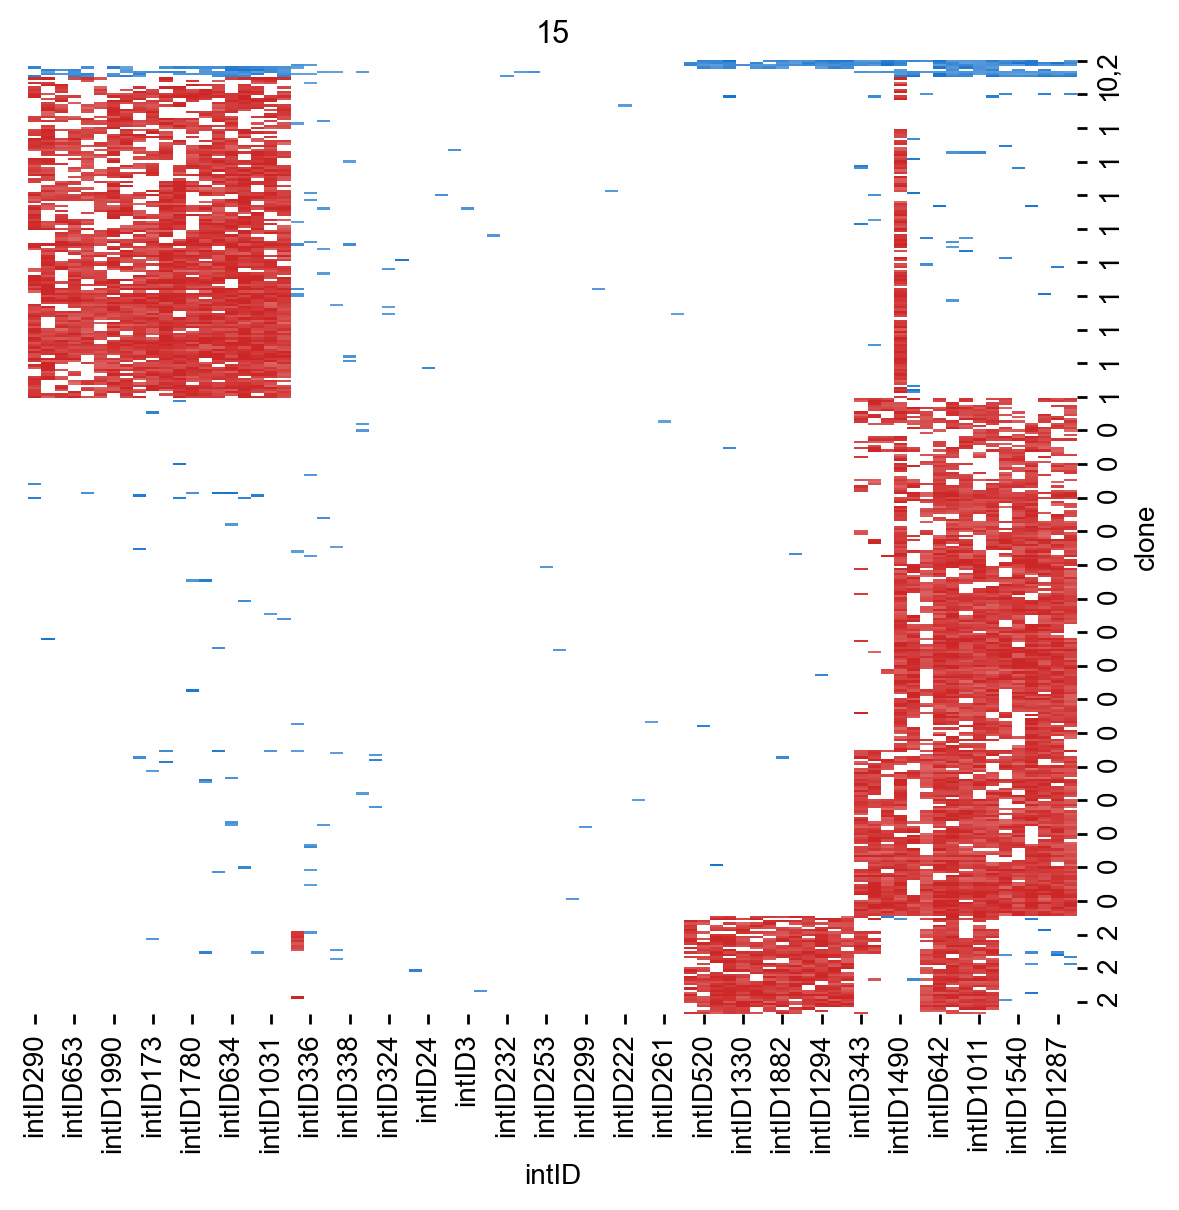

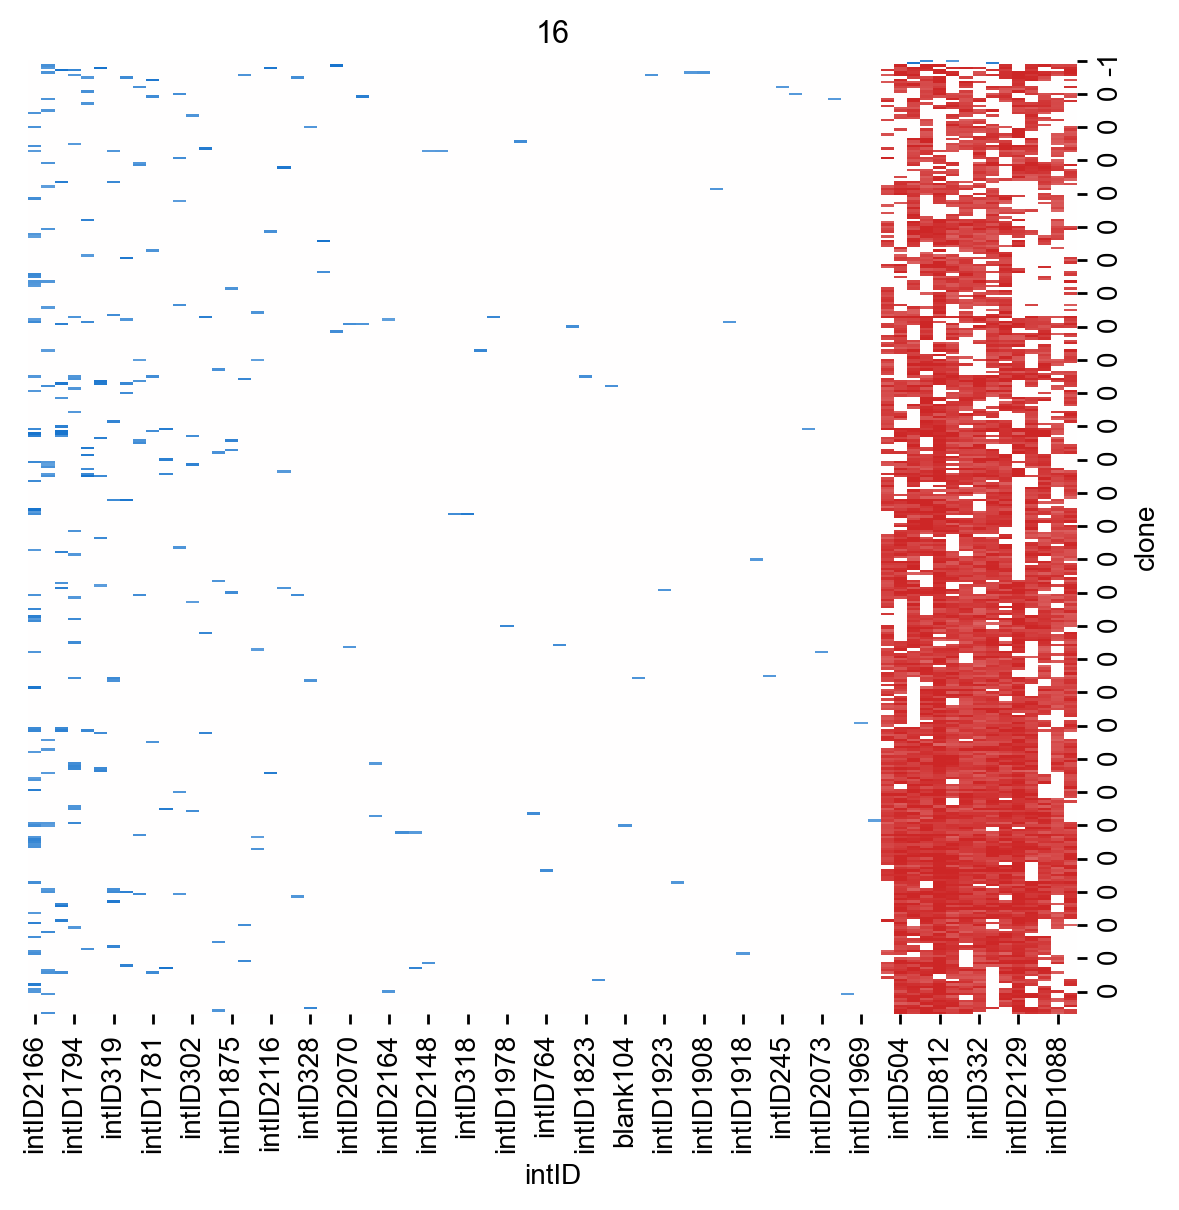

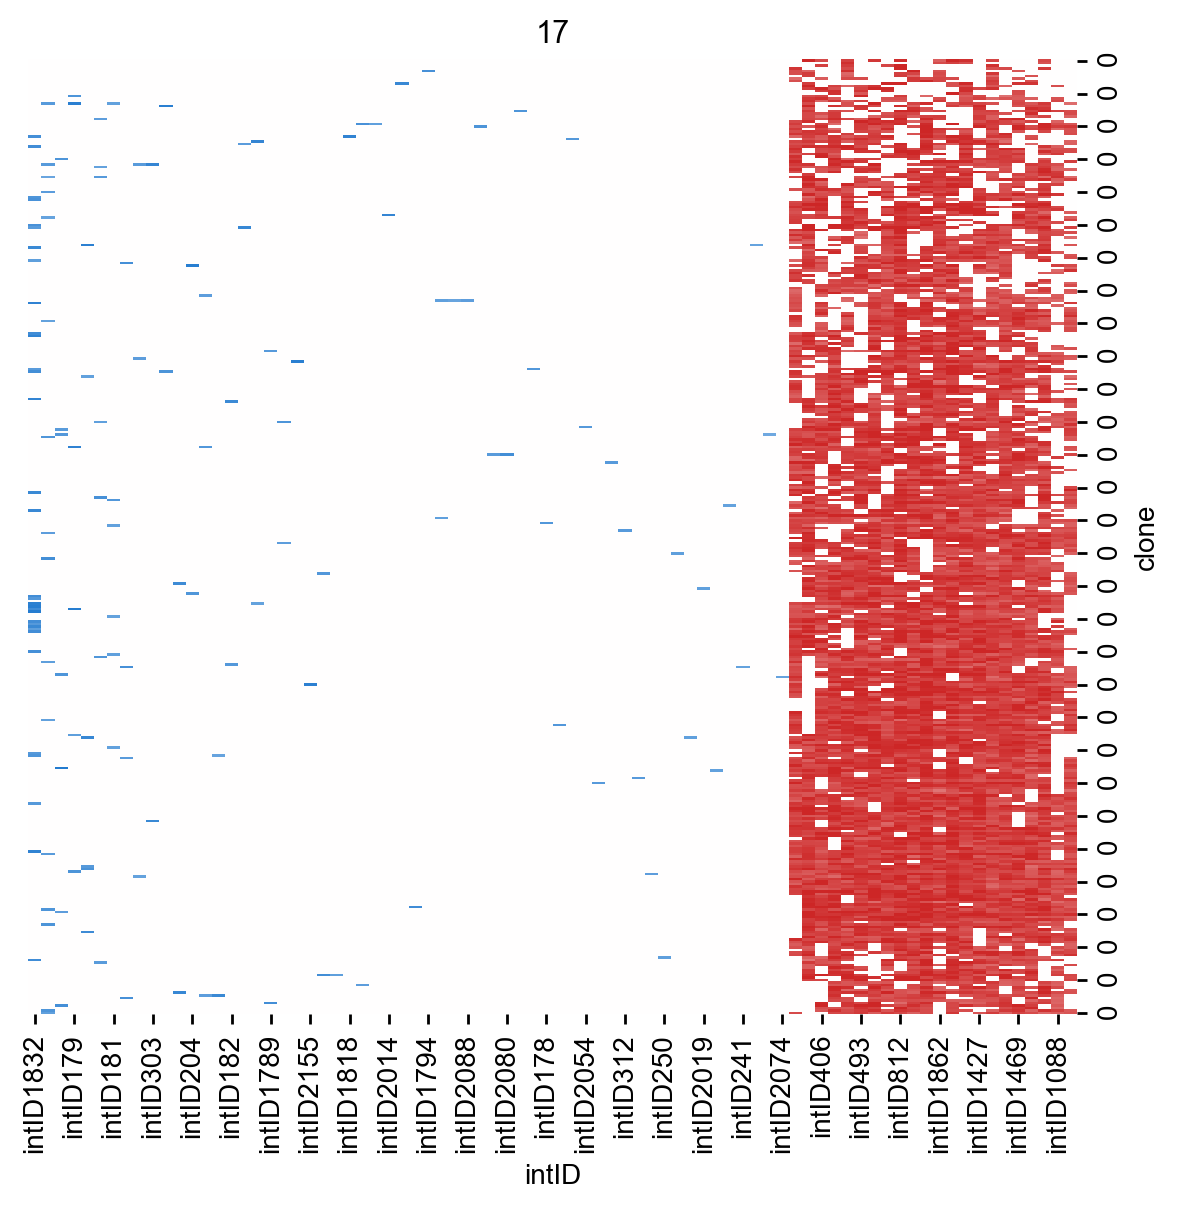

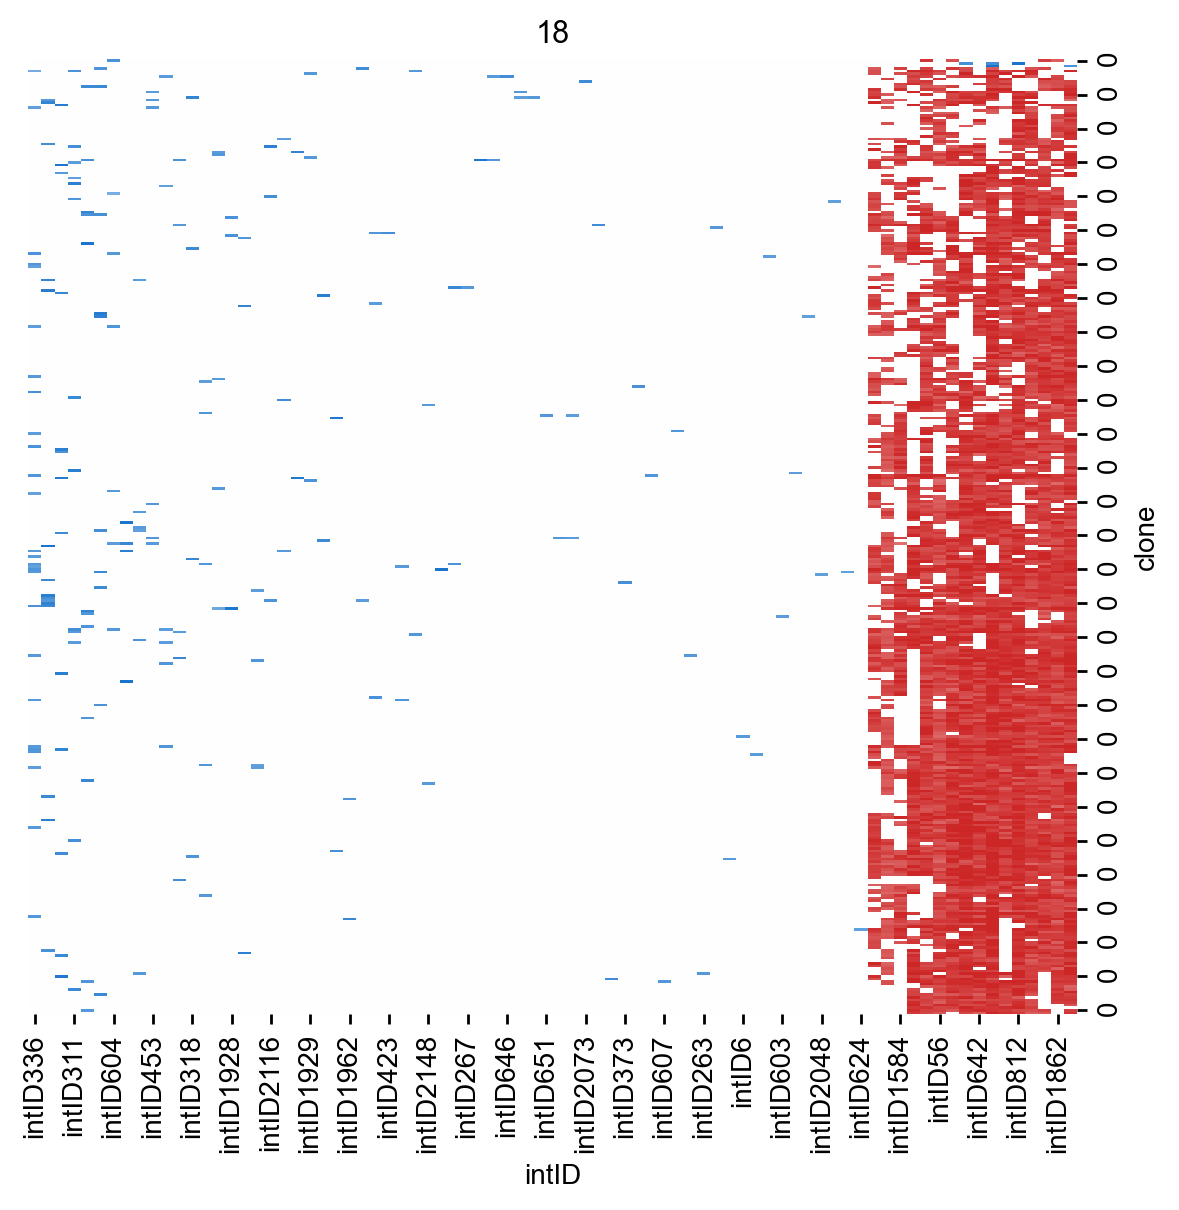

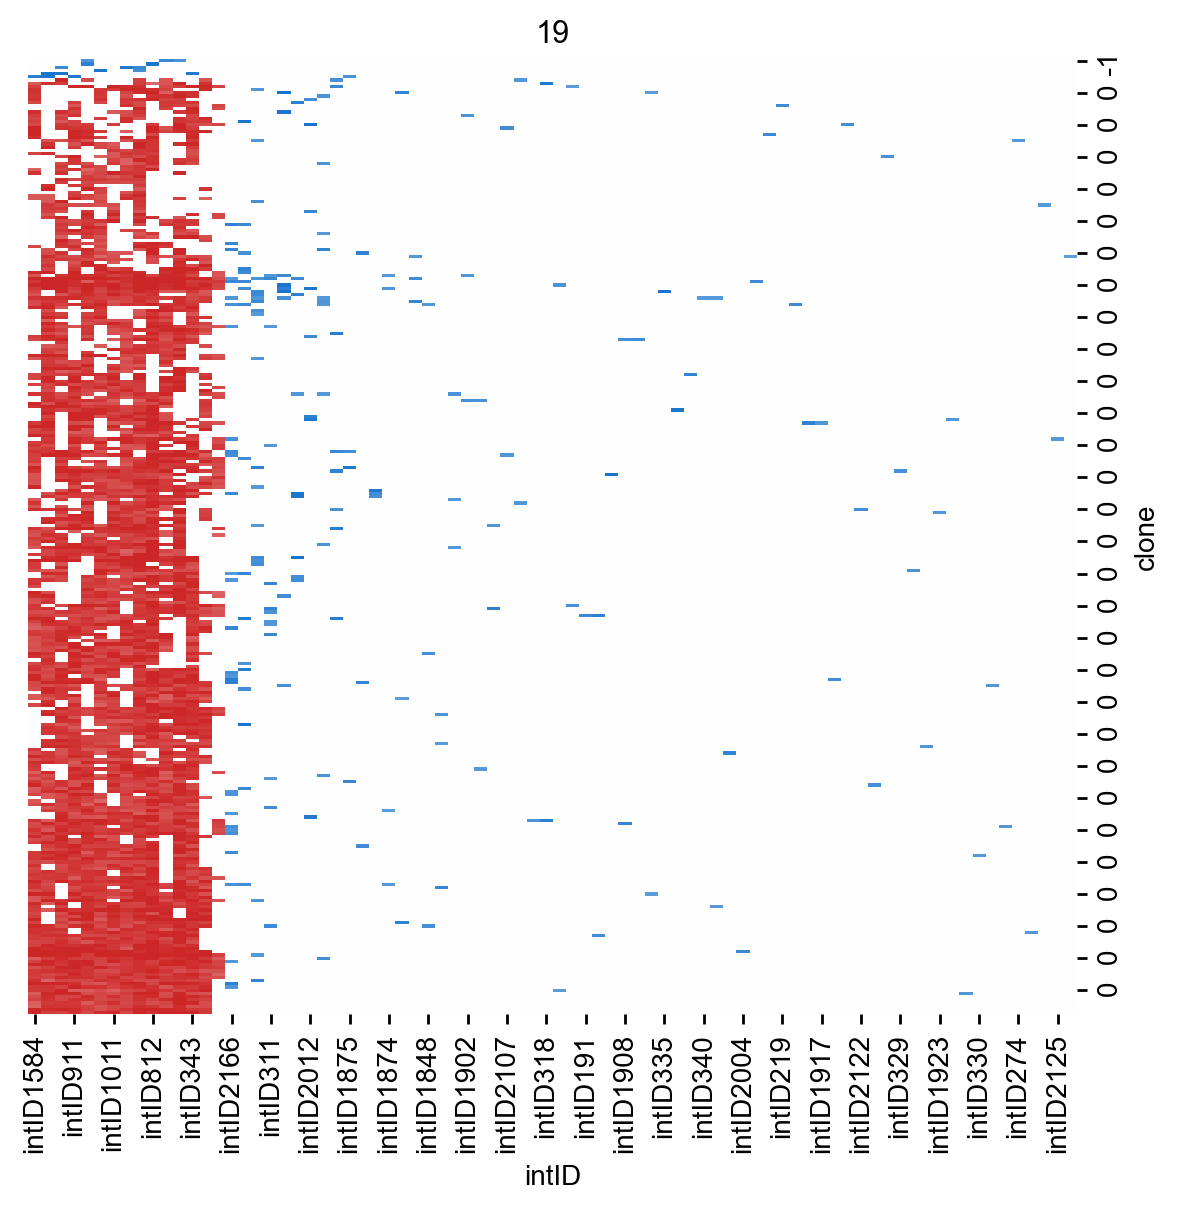

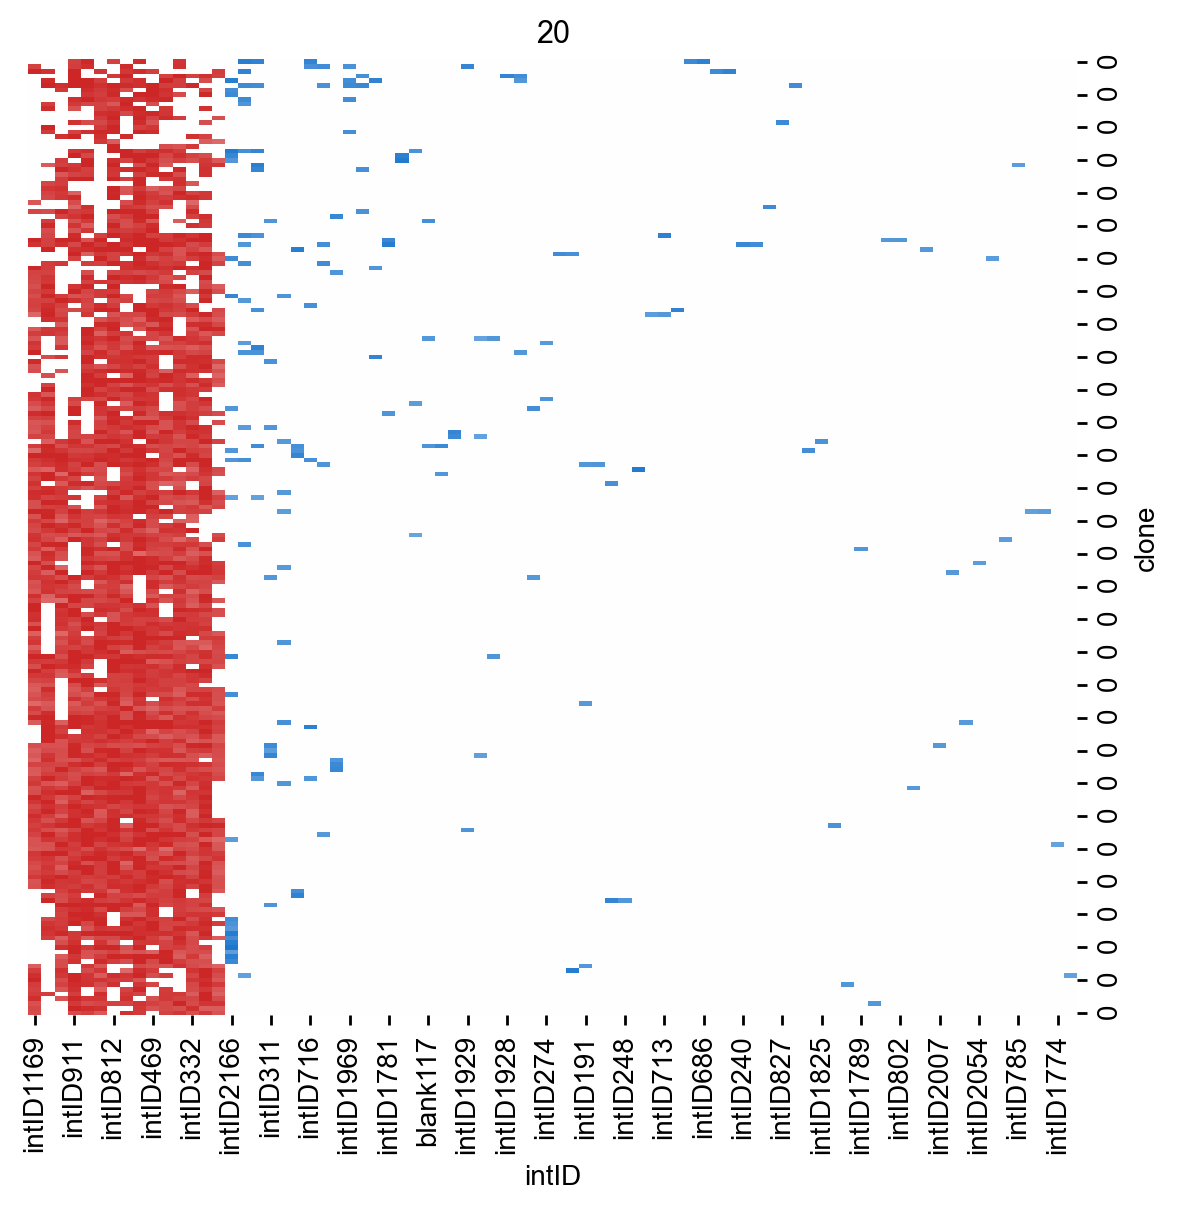

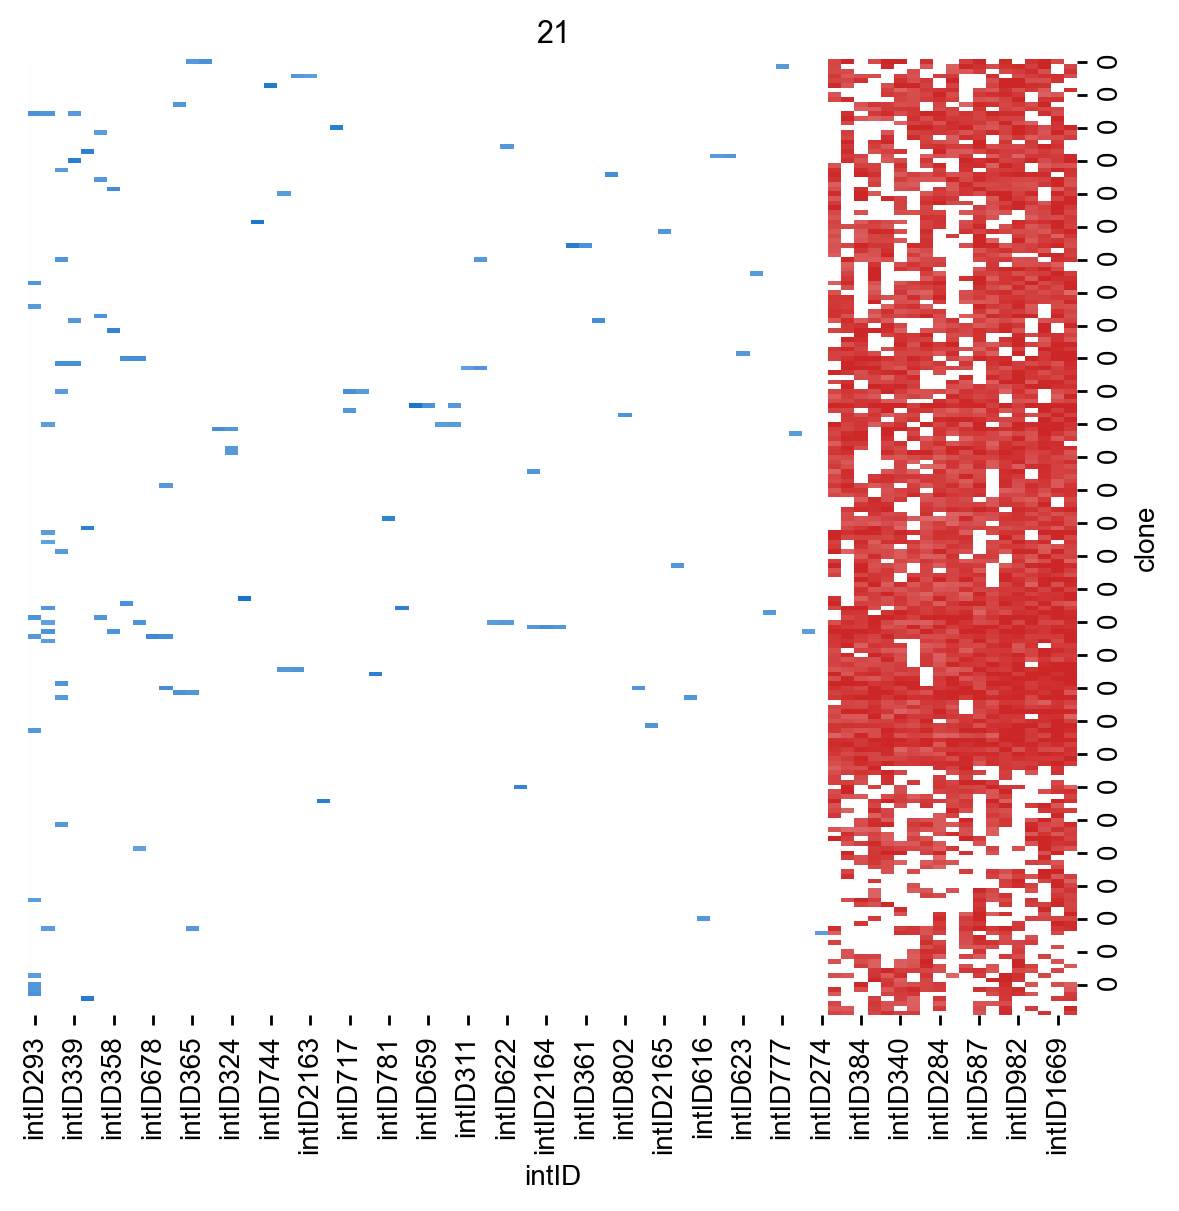

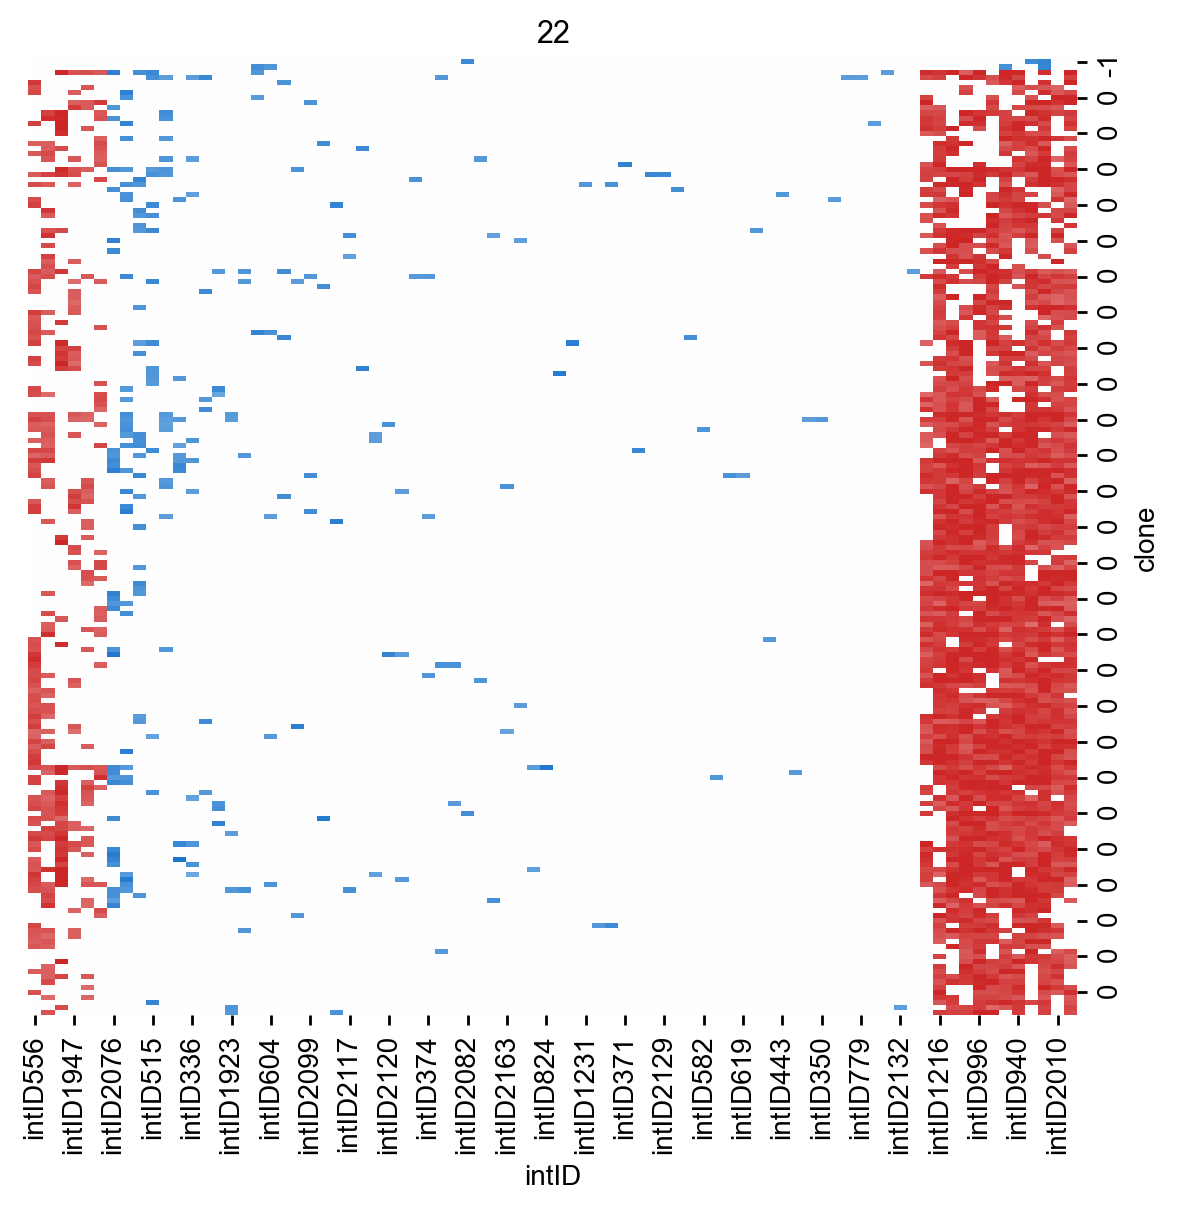

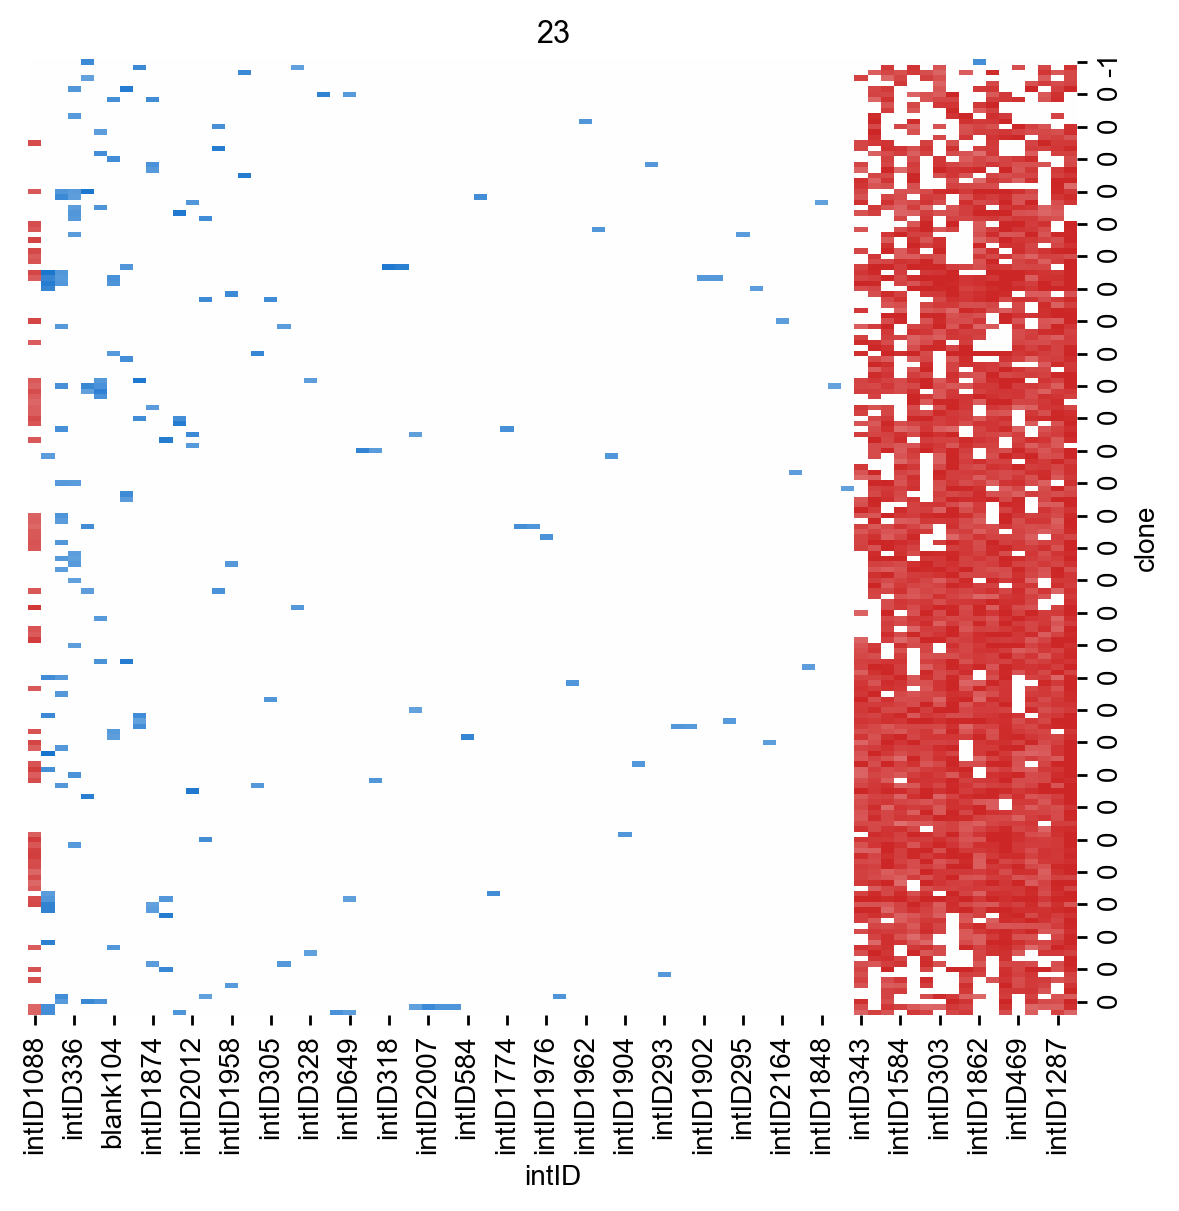

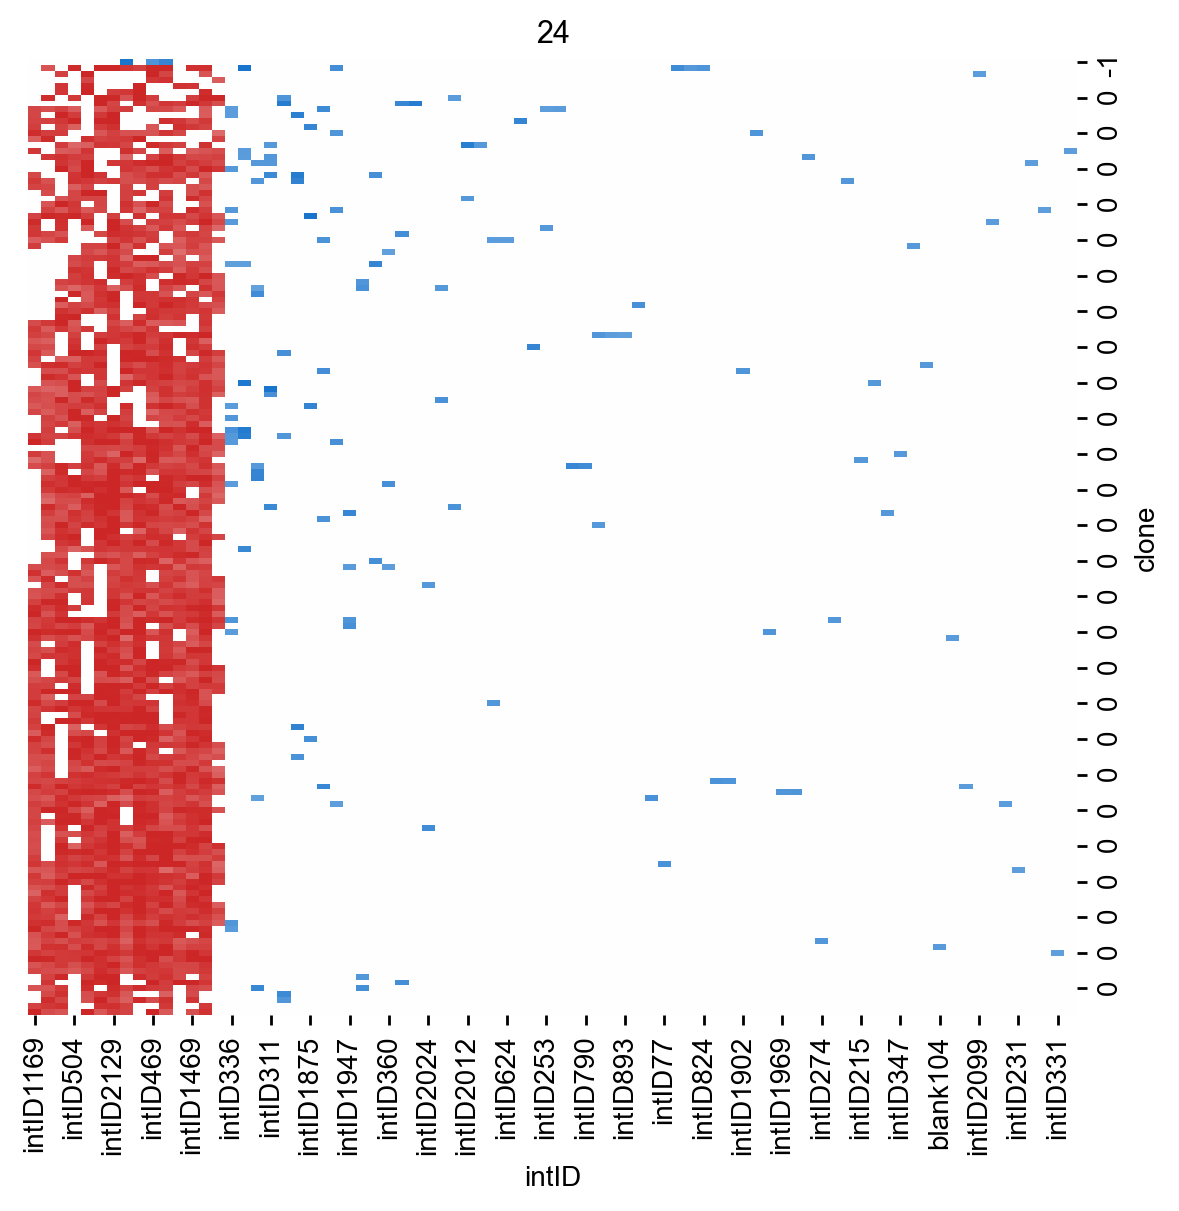

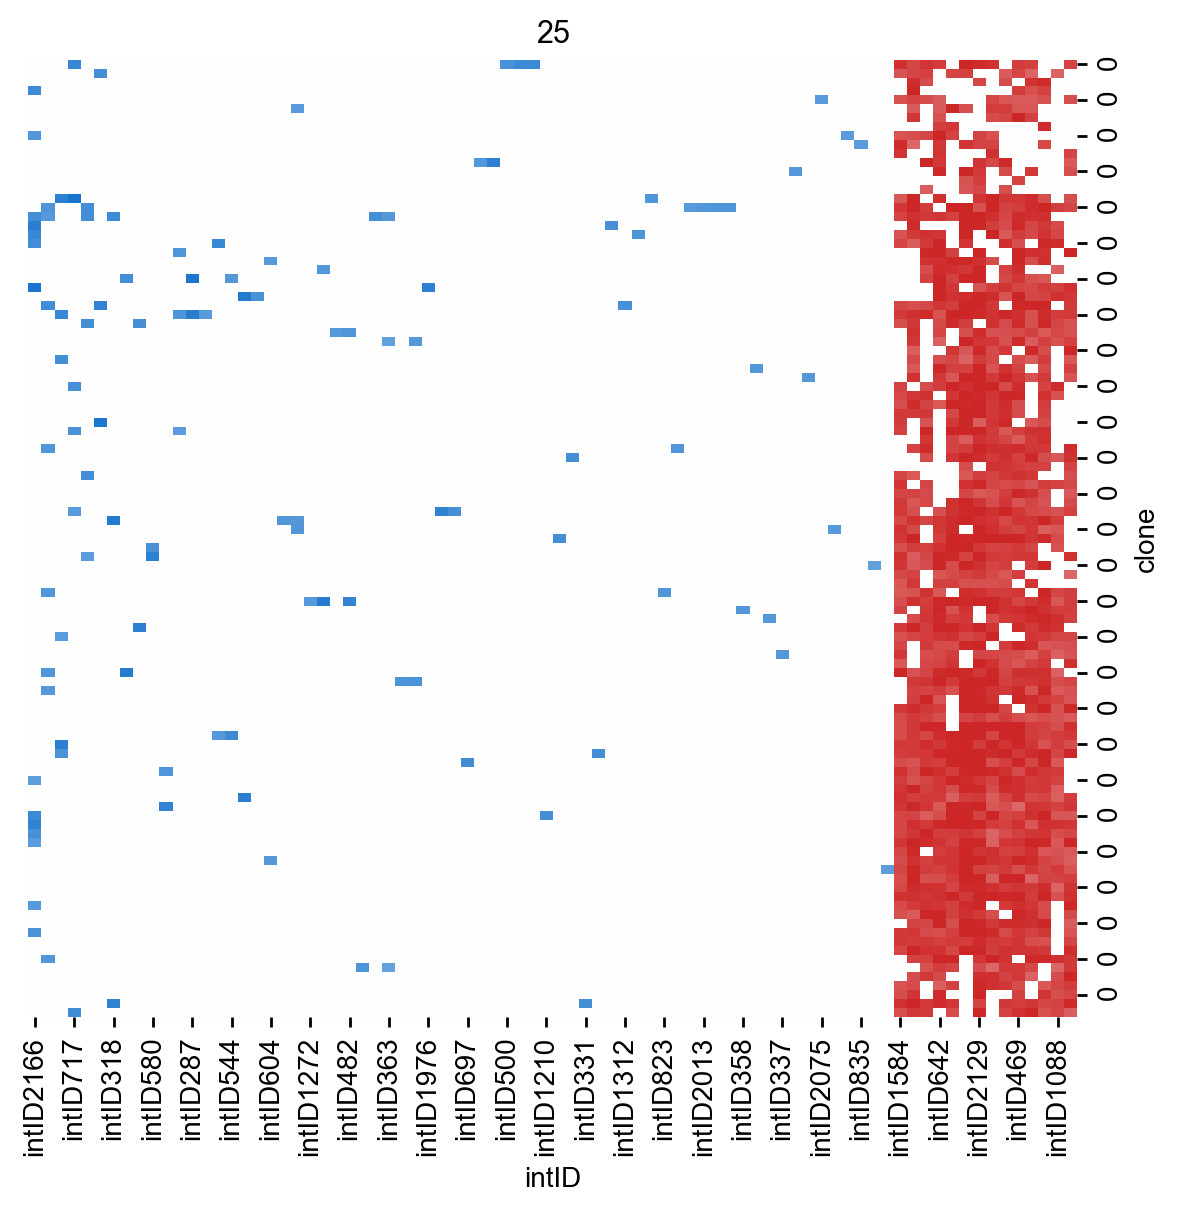

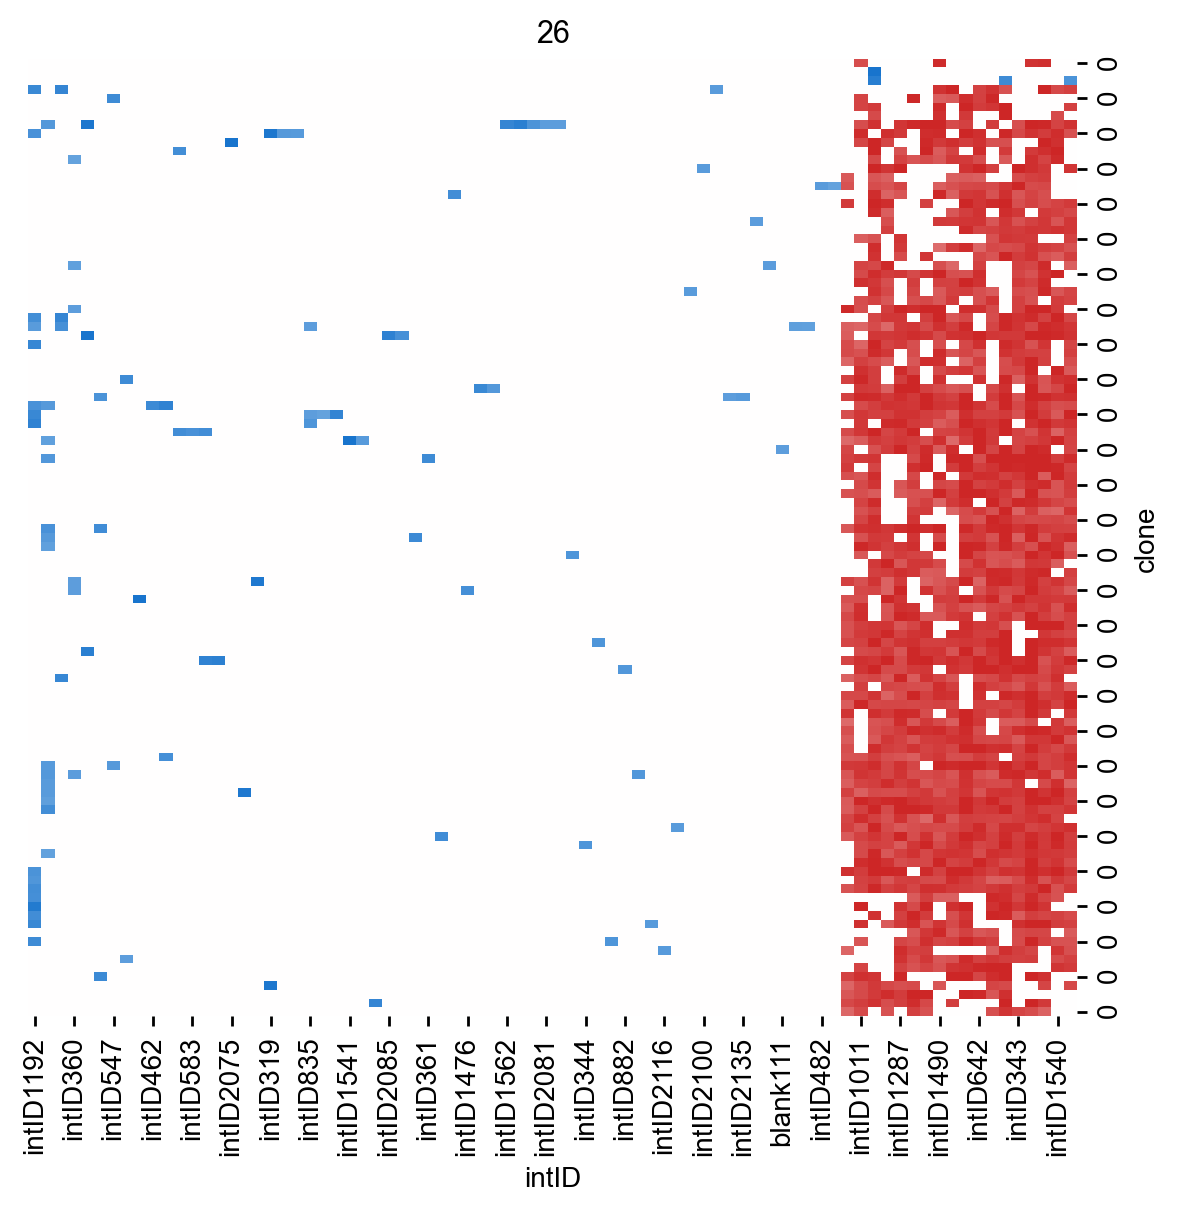

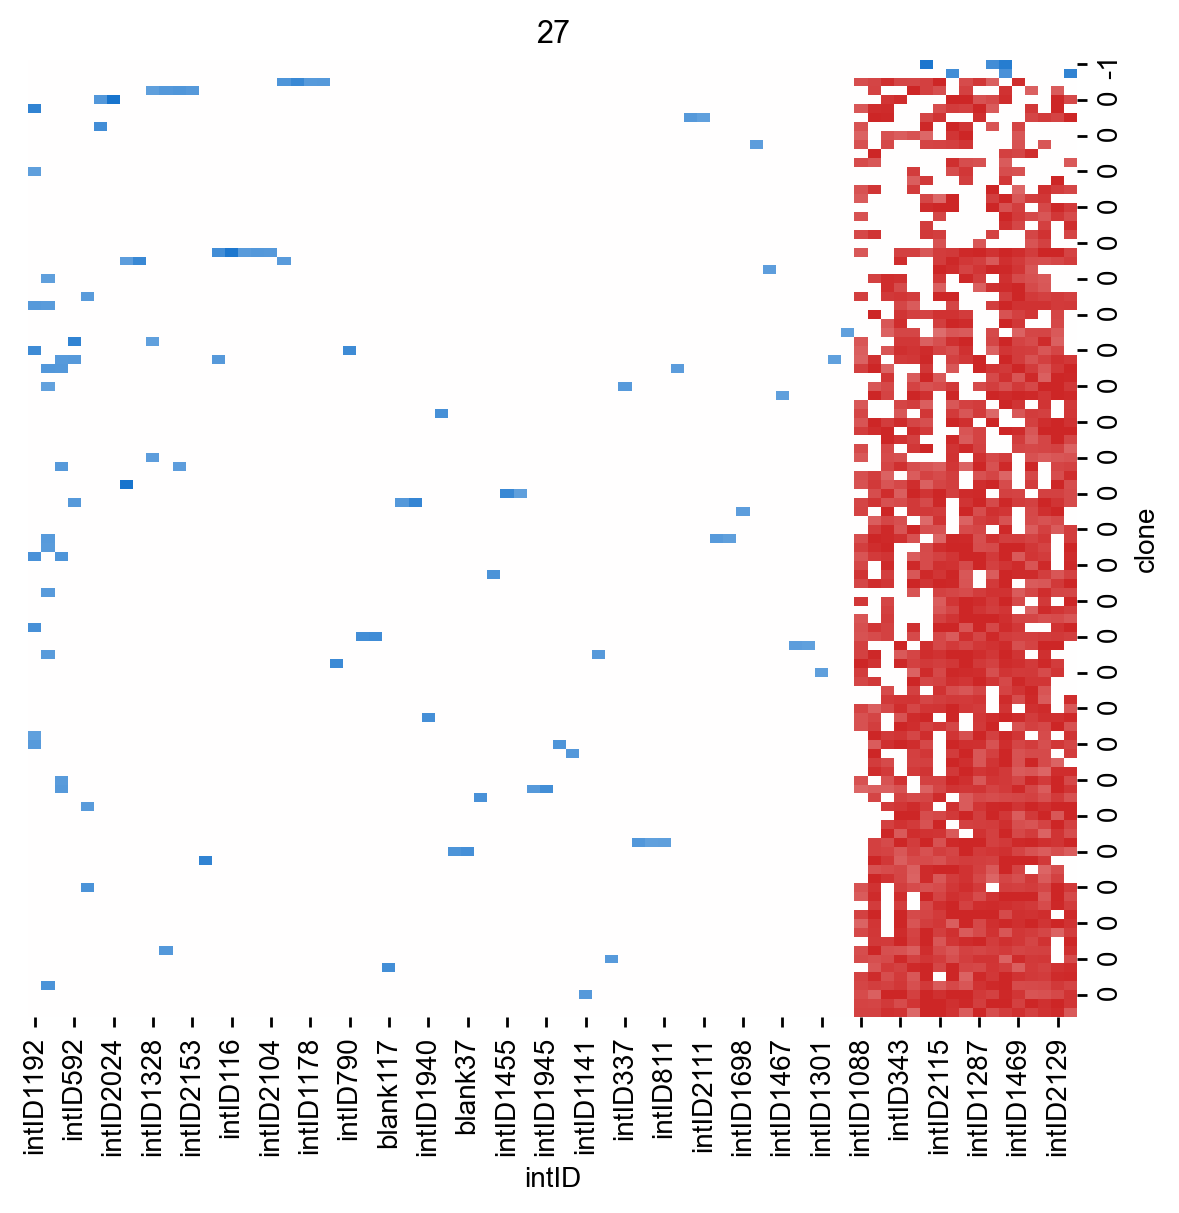

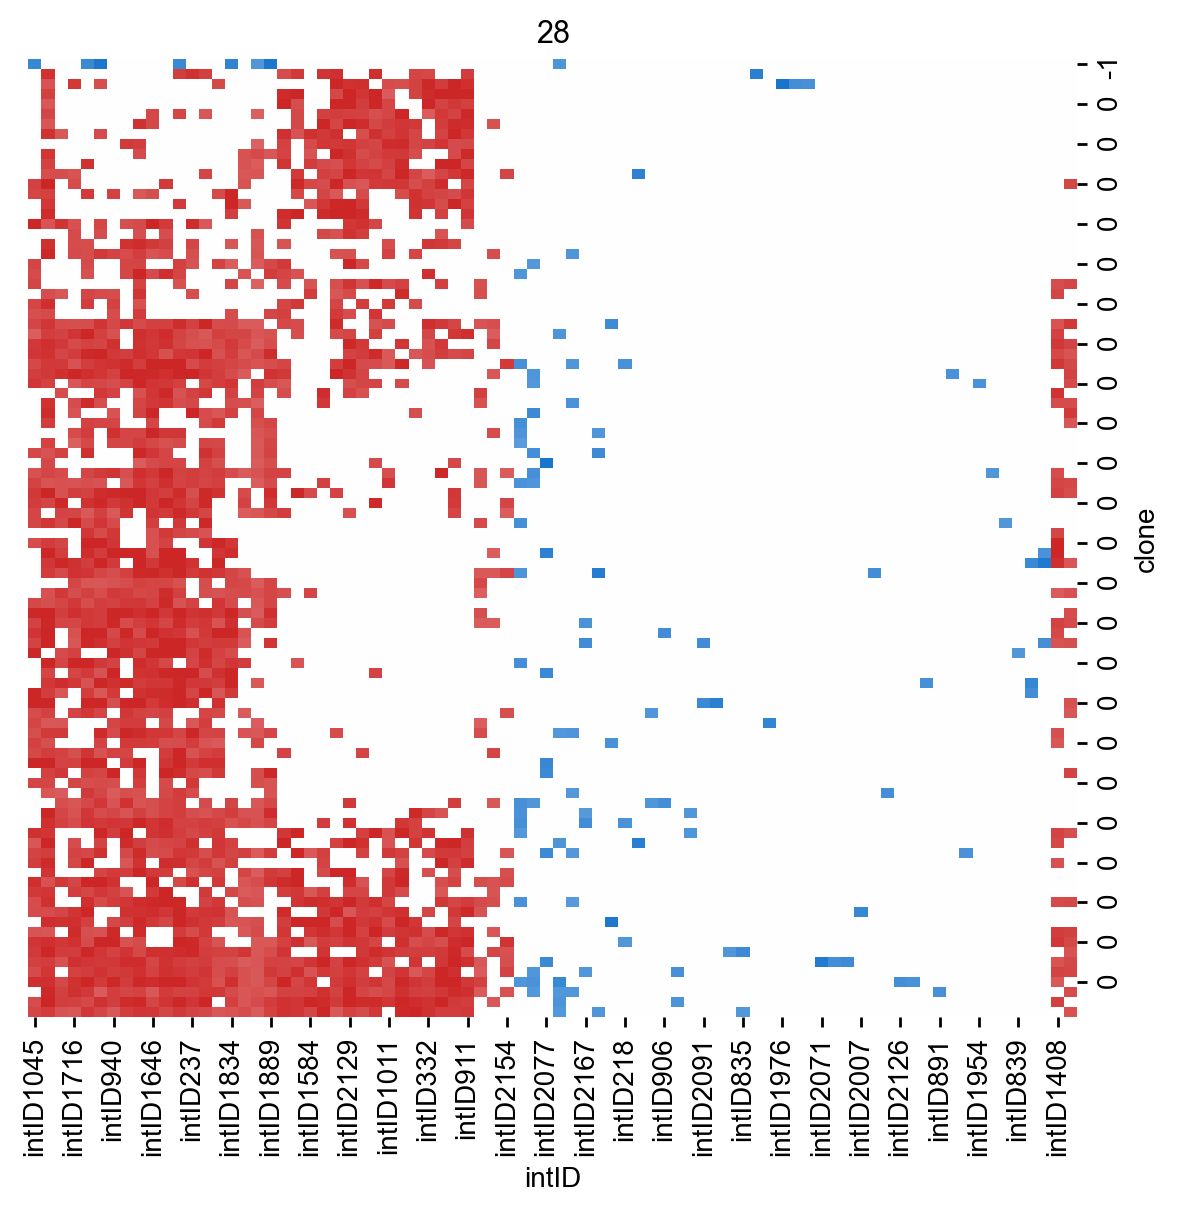

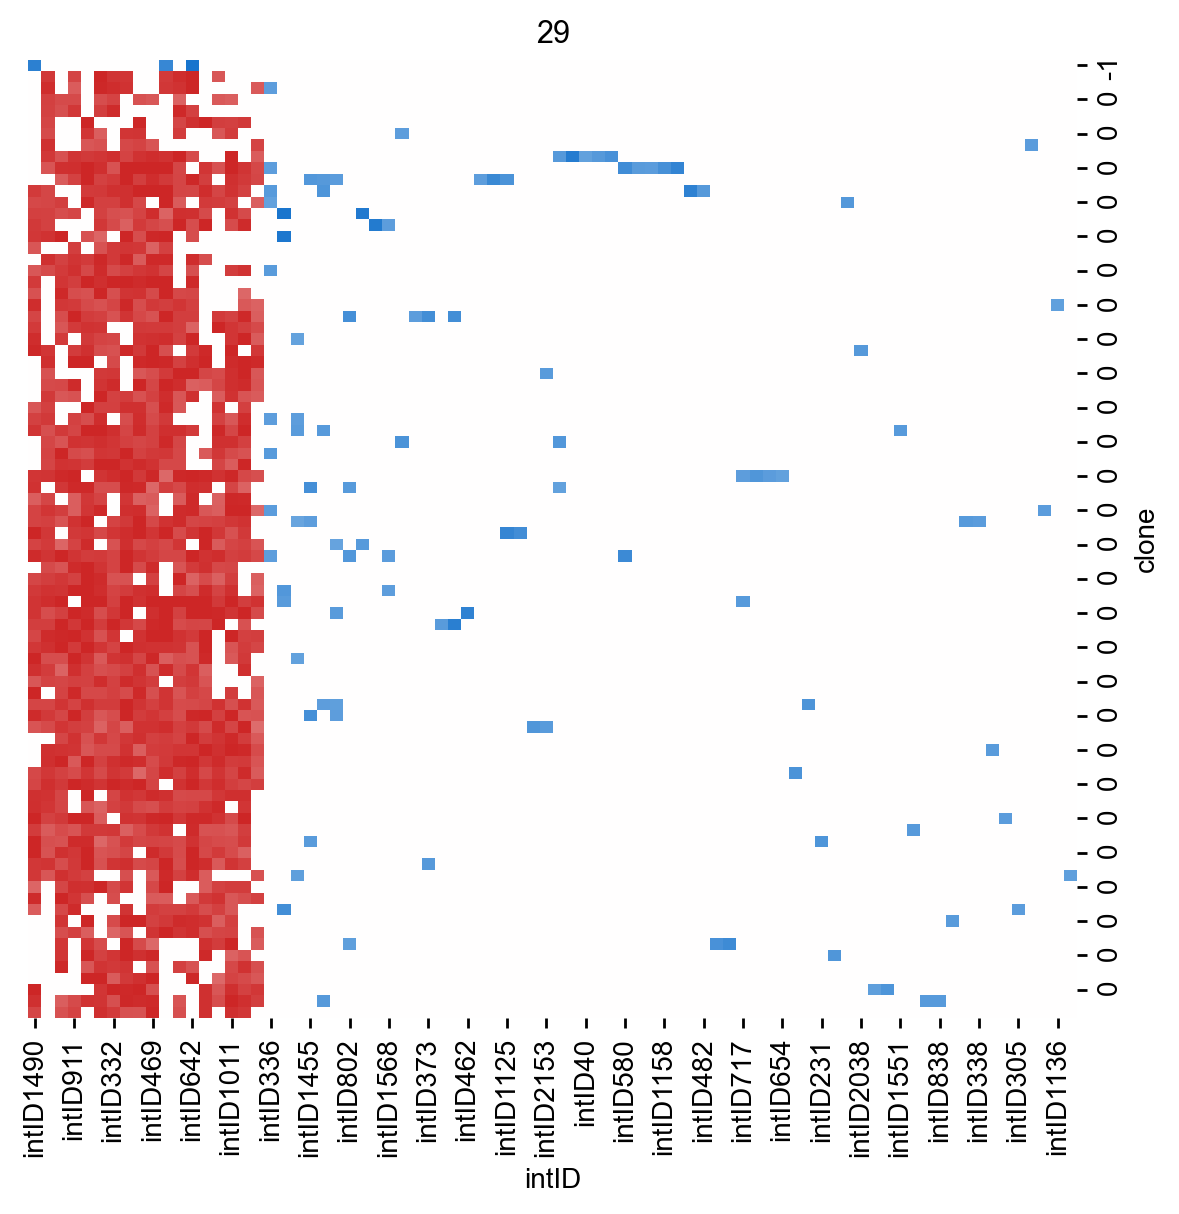

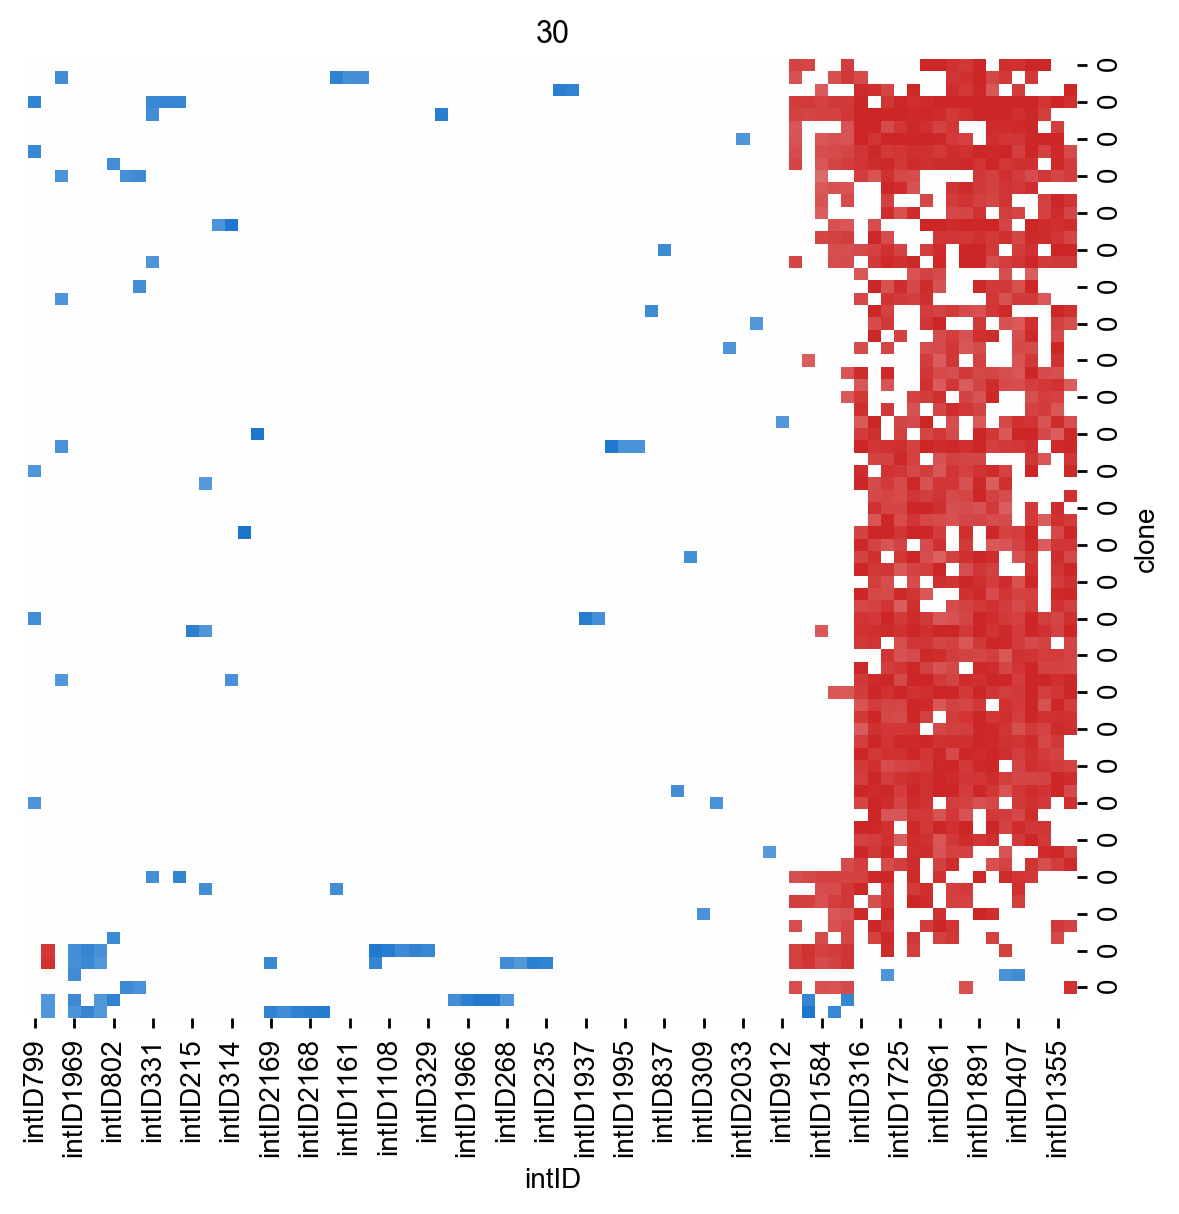

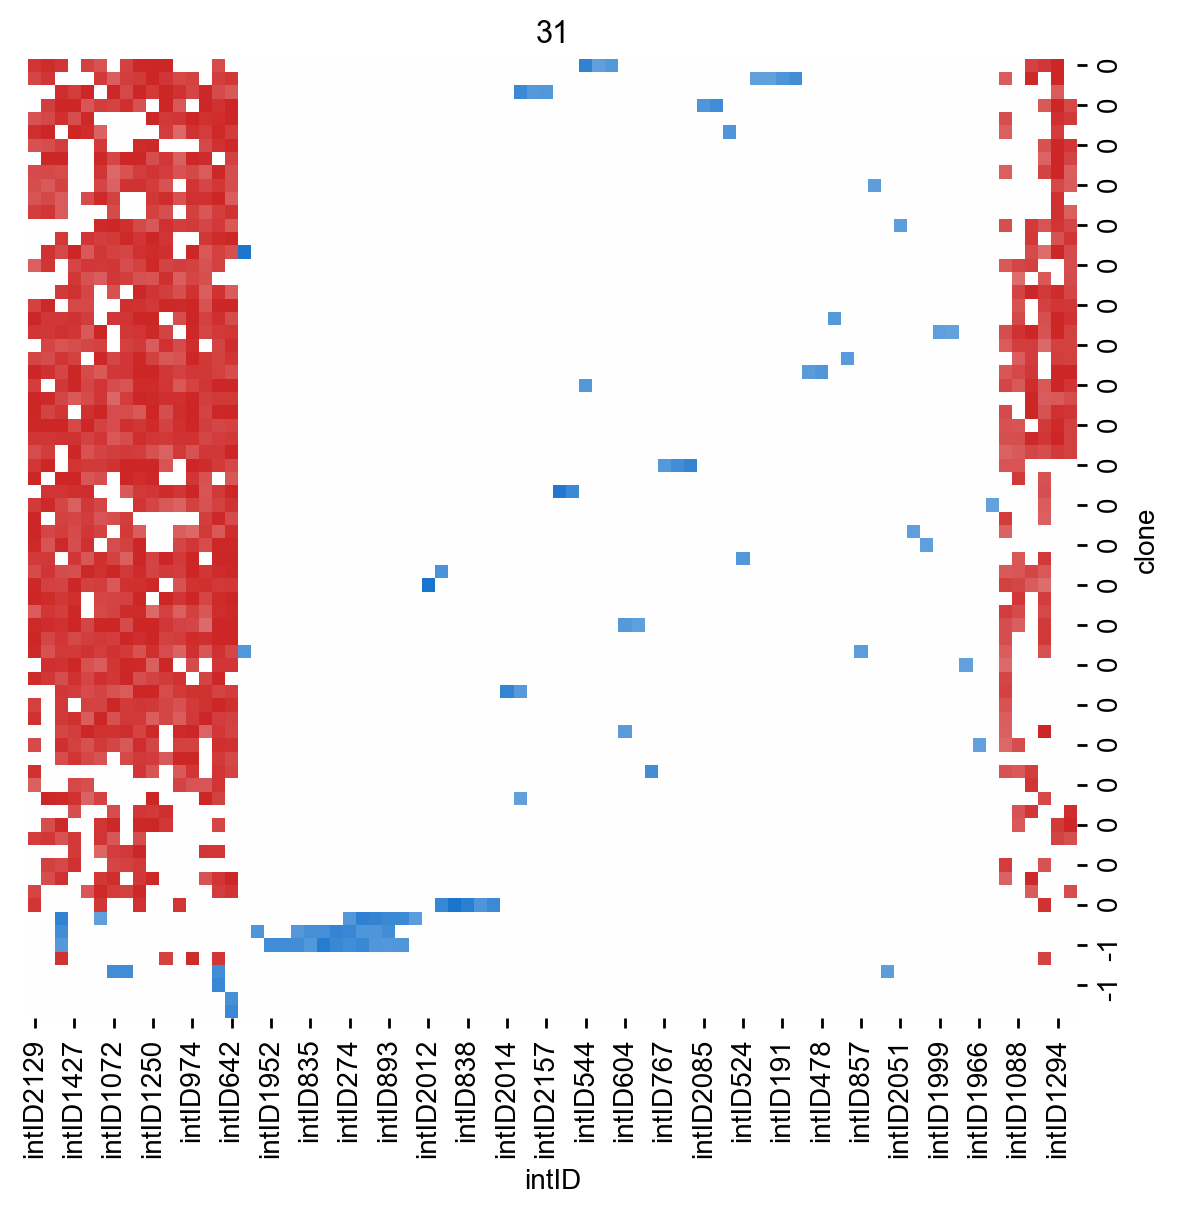

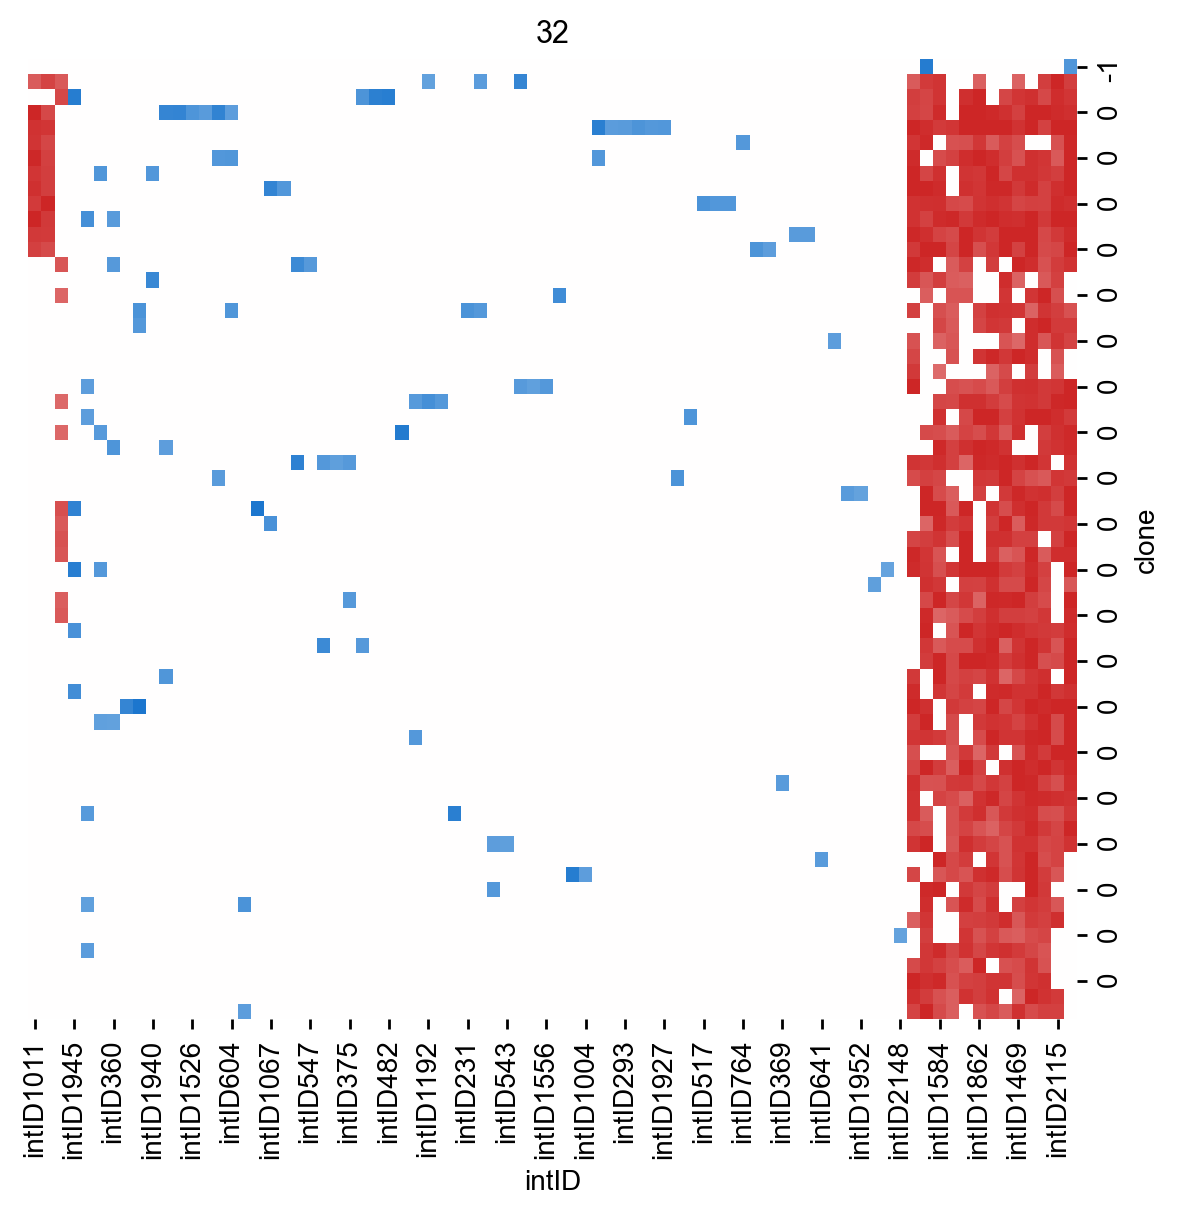

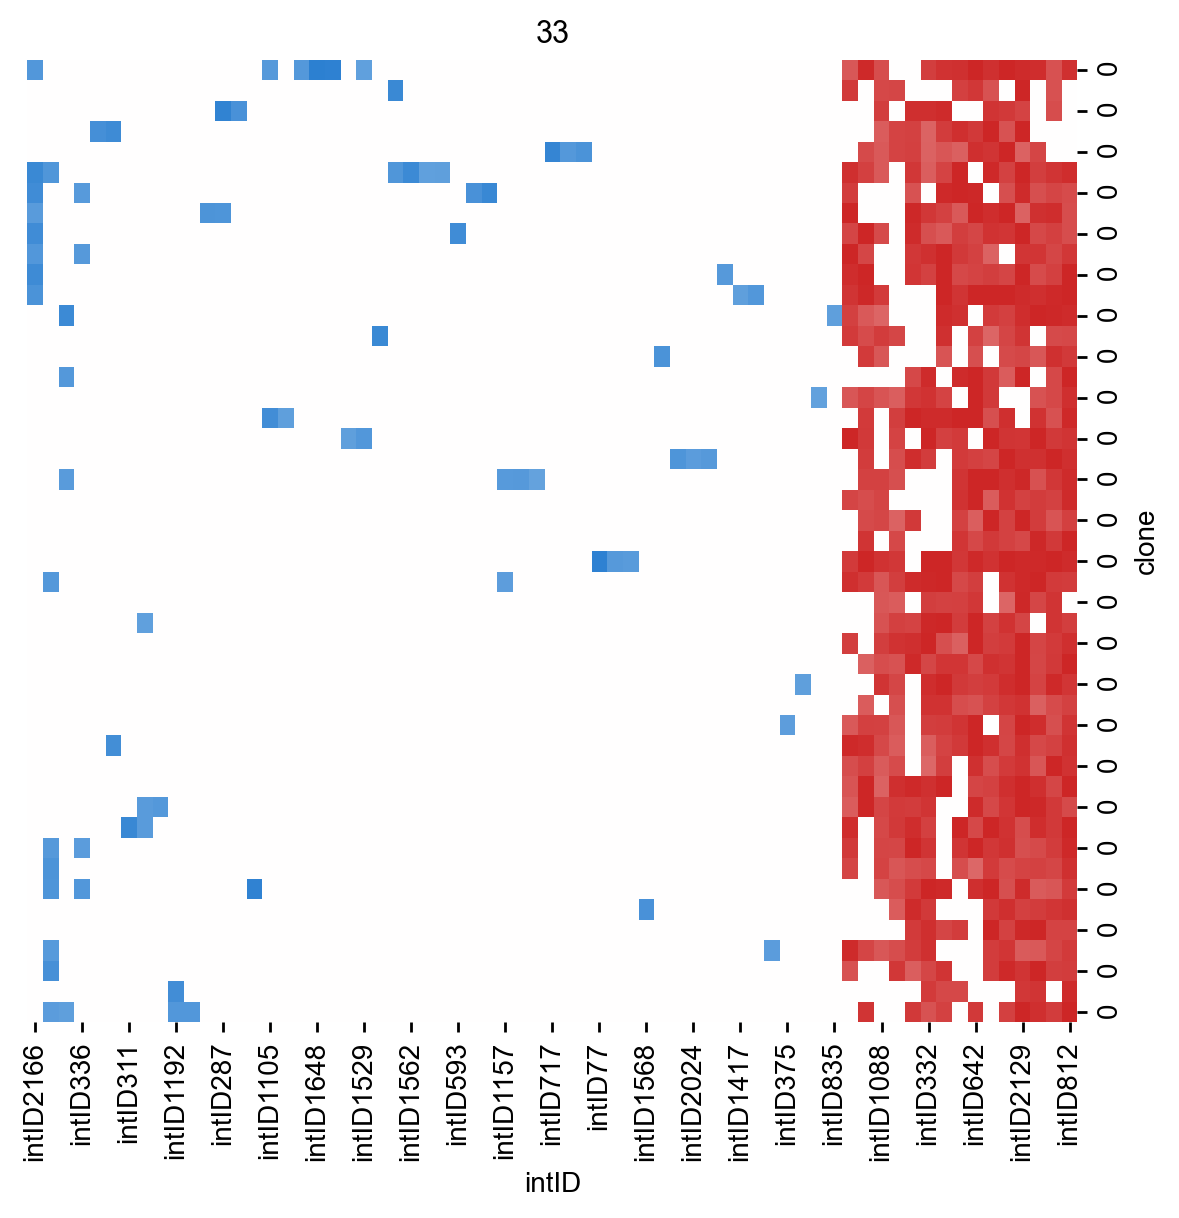

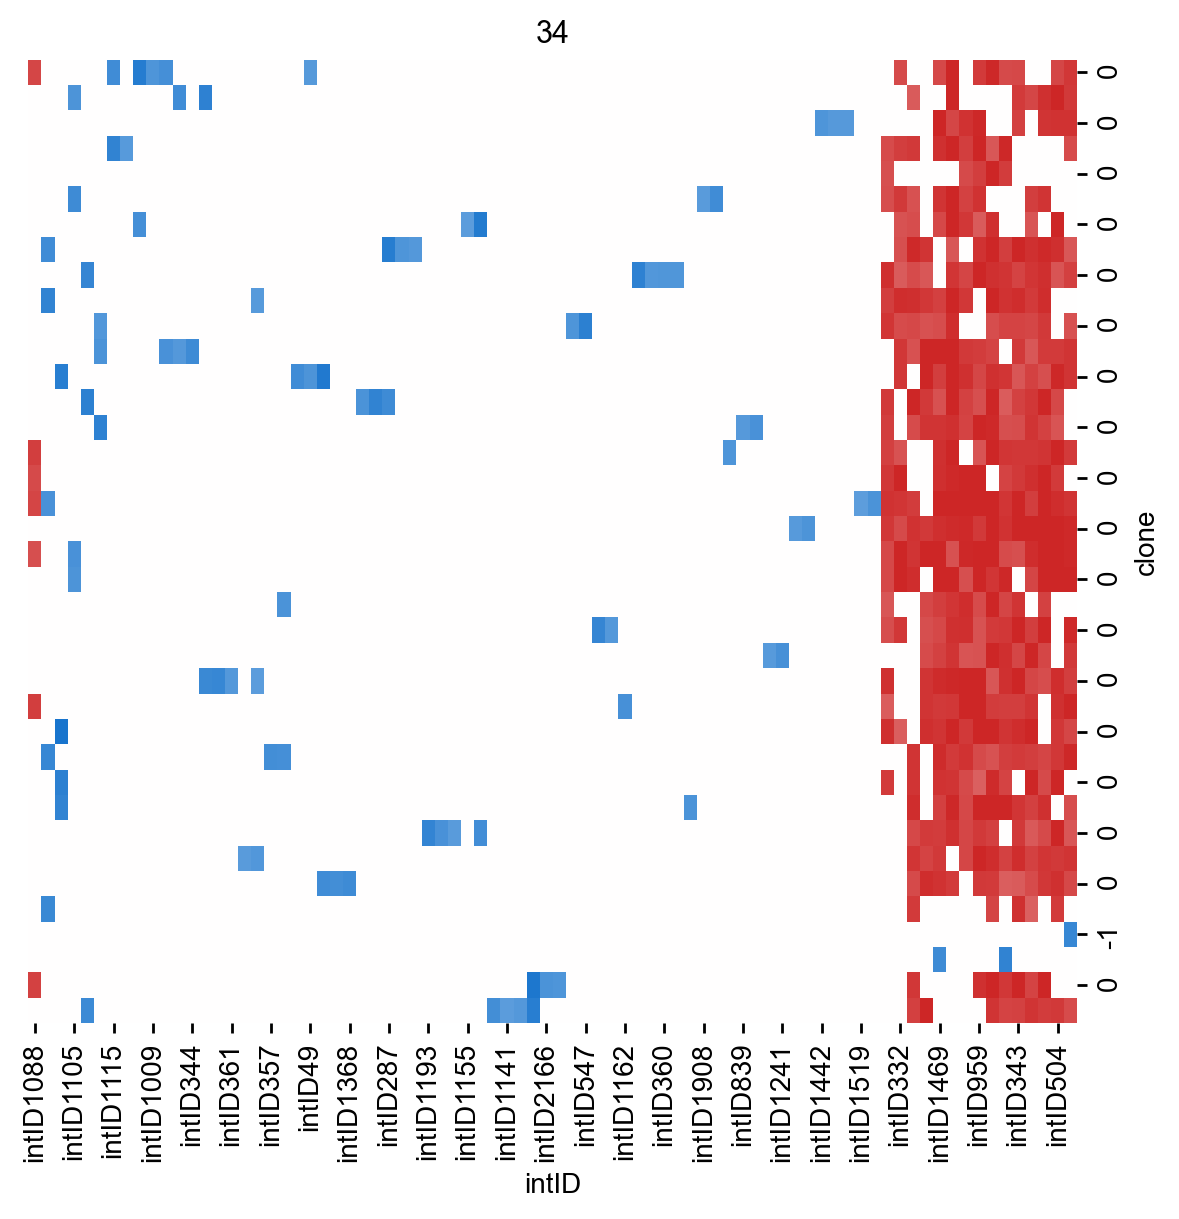

In [194]:
colony_n_clones =  {1:2,2:3,3:2,4:2,5:2,6:2,7:1,8:1,9:2,10:1,
                    11:2,12:1,13:1,14:1,15:3,16:1,17:1,18:1,19:1,20:1,
                    21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1,
                    31:1,32:1,33:1,34:1}
min_frac = .2
min_jaccard = .2
whitelist_alleles = []
cell_to_clone = []
for colony, n_clones in colony_n_clones.items():
    model = SpectralClustering(n_clusters=n_clones)
    colony = str(colony)
    colony_alleles, colony_clones = call_clones(filtered_alleles.query("colony == @colony"),
                                                model,plot_title = colony,min_frac=min_frac,min_jaccard=min_jaccard,top_n=80)
    whitelist_alleles.append(colony_alleles)
    cell_to_clone.append(colony_clones.assign(colony = colony))
whitelist_alleles = pd.concat(whitelist_alleles)
cell_to_clone = pd.concat(cell_to_clone)

Rename clones by size

In [195]:
clone_counts = cell_to_clone.query("whitelist").groupby(["colony","clone"]).size().reset_index(name = "n").sort_values("n",ascending = False)
clone_counts["unique_clone"] = (clone_counts.reset_index().index + 1).astype(str)
cell_to_clone = cell_to_clone.merge(clone_counts[["colony","clone","unique_clone"]], on = ["colony","clone"], how = "left")
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])
filtered_alleles = whitelist_alleles.copy()
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])

Mark doublets and unassigned cells

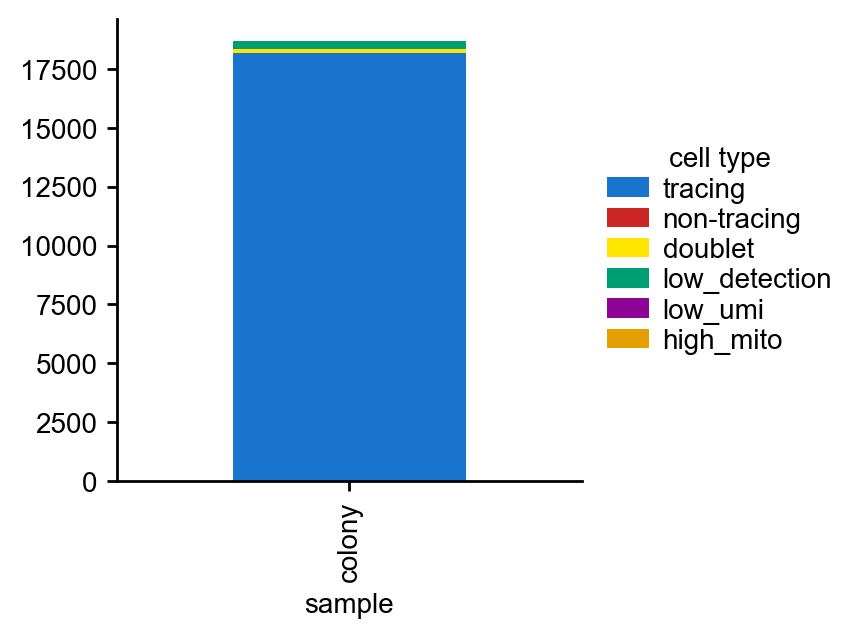

In [196]:
doublets = cell_to_clone.query("clone.str.contains(',')")["cellBC"]
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs.loc[(adata.obs.type == "tracing") & adata.obs.clone.isna(), "type"] = "low_detection"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

Spatial organization of clones

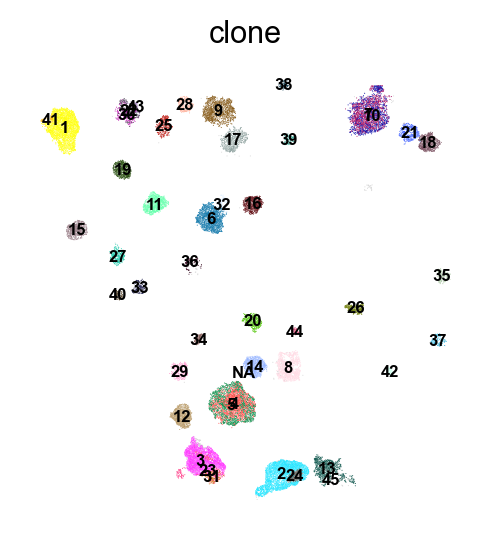

In [197]:
sc.pl.spatial(adata, color = "clone",legend_loc = "on data",spot_size=20,legend_fontsize = 6,frameon=False)

## Resolve allele conflicts

Select brightest spot within the nucleus for each allele

In [198]:
filtered_alleles["in_nucleus"] = filtered_alleles["cell_dist"] == 0
filtered_alleles = filtered_alleles.sort_values(["in_nucleus","intBC_intensity"],ascending = False).groupby(
    ["cellBC","intID","HEK3","EMX1","RNF2"]).first().reset_index()
filtered_alleles["n_alleles"] = filtered_alleles.groupby(["clone","cellBC","intID"]).intID.transform("count")

Remove duplicate integrations with conflicts in >40% of cells

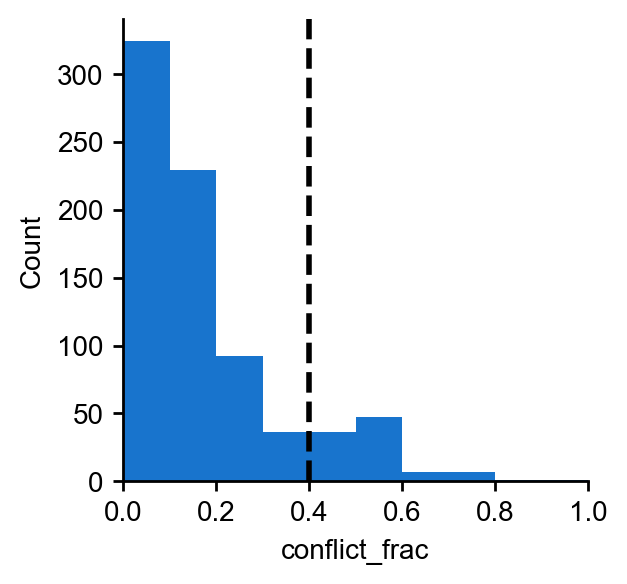

In [199]:
max_int_conflict = .40
int_conflicts = filtered_alleles.query("whitelist").groupby(["clone","cellBC","intID"]).agg({"n_alleles":"first"}).reset_index()
int_conflicts["conflict"] = int_conflicts["n_alleles"] > 1
int_conflicts = int_conflicts.groupby(["clone","intID"]).agg({"conflict":"mean"}).reset_index().rename(columns = {"conflict":"conflict_frac"})
filtered_alleles = filtered_alleles.merge(int_conflicts, on = ["clone","intID"]).query(
    "conflict_frac < @max_int_conflict").copy().drop(columns = "conflict_frac")
sns.histplot(int_conflicts, x = "conflict_frac",bins = 10,multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=max_int_conflict, color="black", linestyle="--")
plt.xlim(0,1);

Mark cells with conflict in > 50% of alleles as doublets

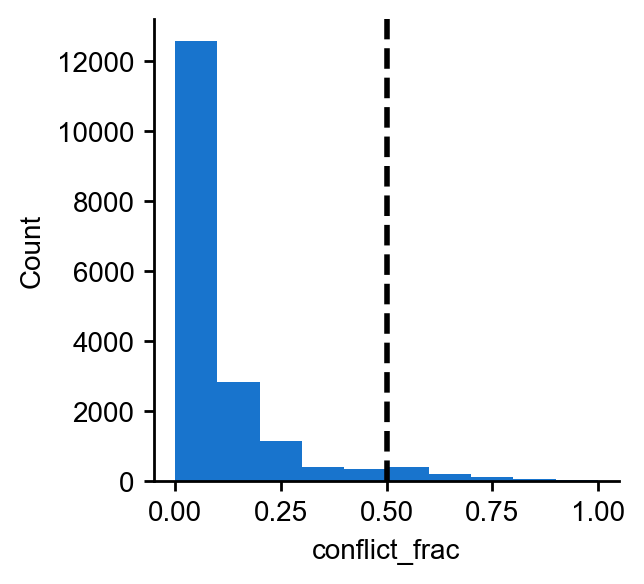

In [200]:
max_cell_conflict = .50
cell_conflicts = filtered_alleles.query("whitelist").groupby(["clone","cellBC","intID"]).agg({"n_alleles":"first"}).reset_index()
cell_conflicts["conflict"] = cell_conflicts["n_alleles"] > 1
cell_conflicts = cell_conflicts.groupby(["clone","cellBC"]).agg({"conflict":"mean"}).reset_index().rename(columns = {"conflict":"conflict_frac"})
doublets = cell_conflicts.query("conflict_frac > @max_cell_conflict")["cellBC"]
sns.histplot(cell_conflicts, x = "conflict_frac",bins = 10,multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=max_cell_conflict, color="black", linestyle="--")

Resolve remaining conflicts by selecting the brightest spot

In [201]:
filtered_alleles = filtered_alleles[~filtered_alleles.cellBC.isin(doublets)].copy()
filtered_alleles = filtered_alleles.sort_values("intBC_intensity",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index().drop(columns = ["n_alleles","in_nucleus"])

Mark doublets

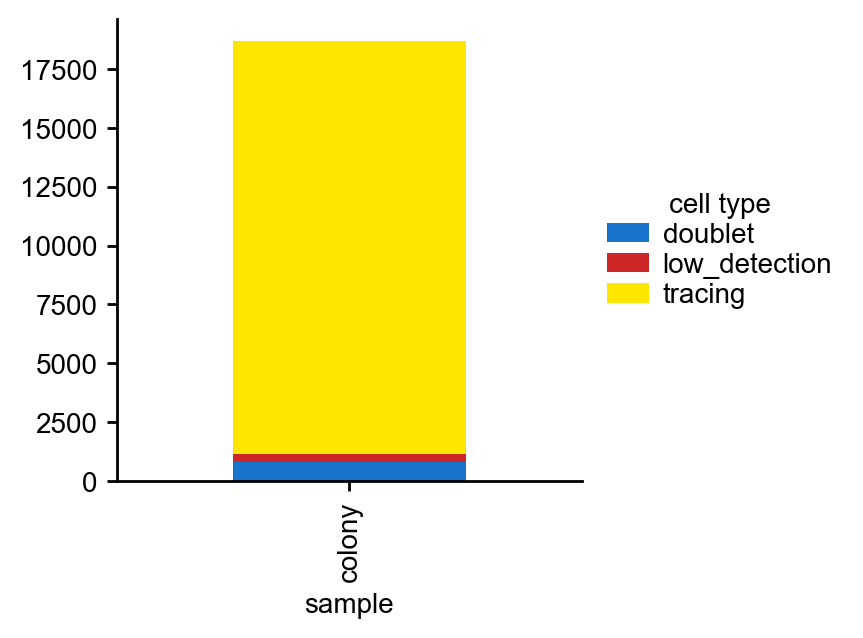

In [ ]:
adata.obs.loc[(adata.obs["type"] == "tracing") & (adata.obs.cellBC.isin(doublets)), "type"] = "doublet"
adata.obs.loc[adata.obs["type"] != "tracing", "clone"] = None
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Allele statistics

In [203]:
tracing_cells = adata.obs.query("type == 'tracing'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@tracing_cells)").copy()

Edit probability vs brightness

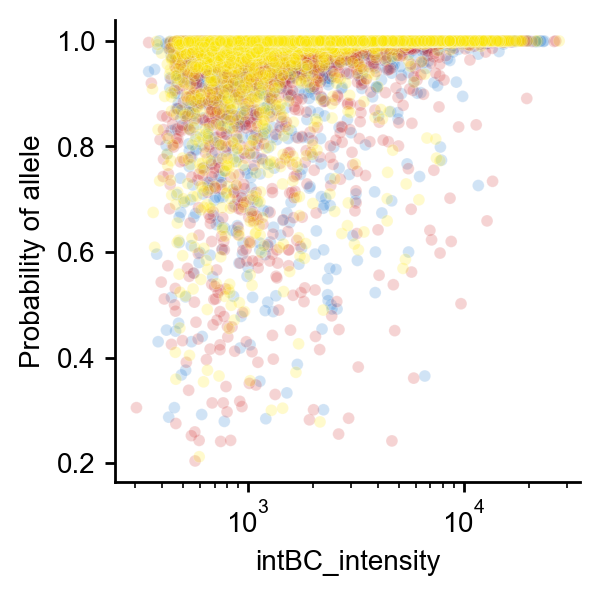

In [204]:
fig, ax = plt.subplots()
for i, site in enumerate(site_names):
    sns.scatterplot(filtered_alleles.sample(5000), x = "intBC_intensity", y = f"{site}_prob",
                    legend=False,alpha = 0.2,size = .1,ax = ax)
plt.xscale("log");
plt.ylabel("Probability of allele");

Detection rate per clone

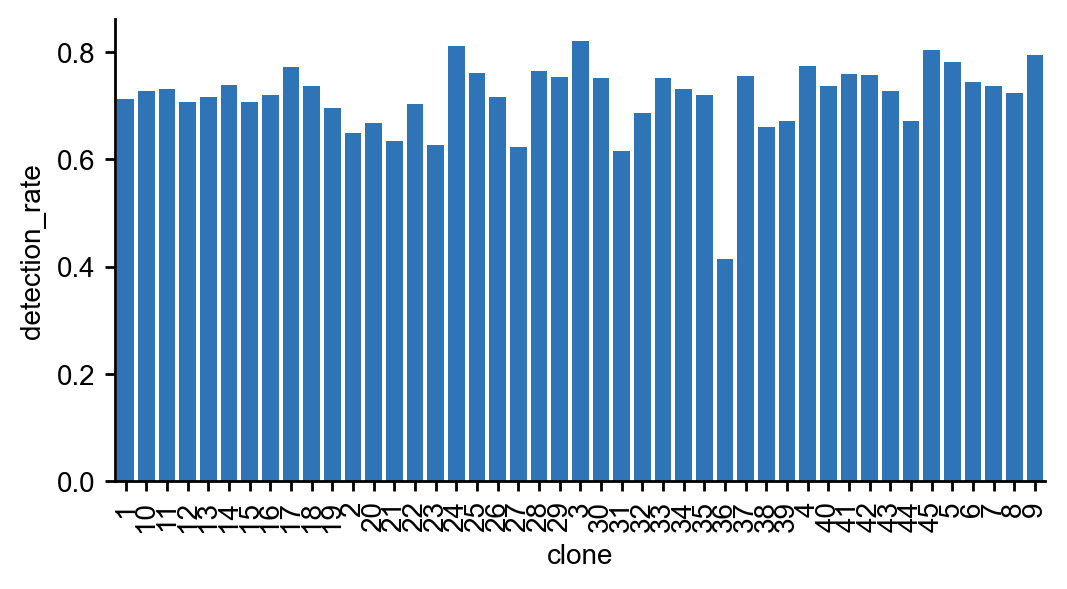

In [205]:
int_detection = (filtered_alleles.query("whitelist").groupby(["intID","clone","sample"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["cellBC"].nunique())
int_detection = int_detection.reset_index(name = "detection_rate")
fig, ax = plt.subplots(figsize = (6,3))
sns.barplot(data = int_detection.groupby(["clone"]).agg({"detection_rate":"mean"}).reset_index(),
            y = "detection_rate",x = "clone",ax = ax)
plt.xticks(rotation=90);

Detection rate per integration

<Axes: xlabel='clone', ylabel='intID'>

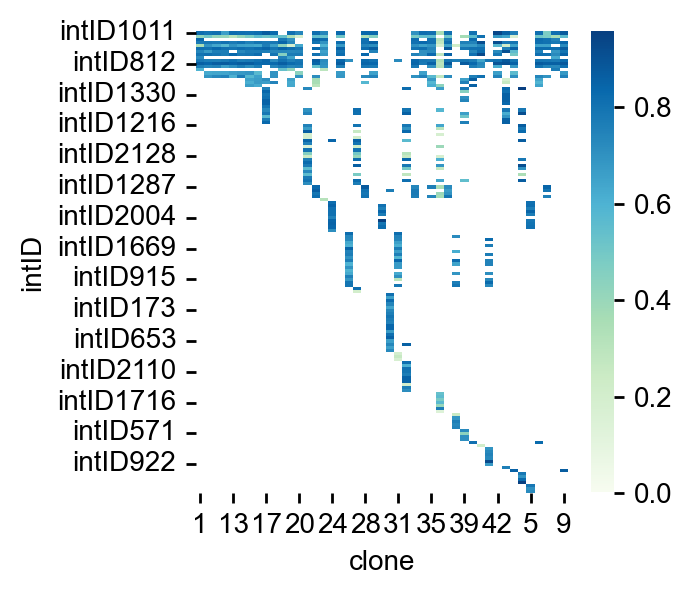

In [206]:
int_order = int_detection.intID.drop_duplicates()
int_detection_wide = pd.pivot_table(int_detection,columns=["clone"], index=["intID"], values="detection_rate")
sns.heatmap(int_detection_wide.loc[int_order,:],cmap = sequential_cmap,vmin = 0)

Detection rate per cell

<Axes: xlabel='detection_rate', ylabel='Count'>

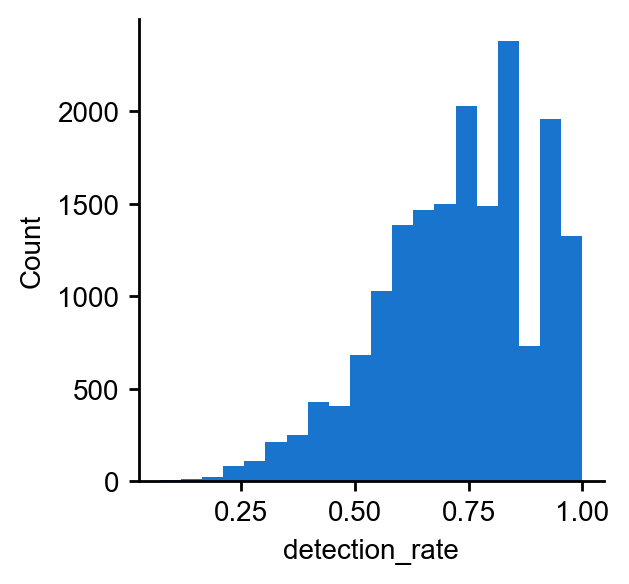

In [207]:
cell_detection = (filtered_alleles.query("whitelist").groupby(["clone","sample","cellBC"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["intID"].nunique()).reset_index(name = "detection_rate")
adata.obs["detection_rate"] = adata.obs["cellBC"].map(cell_detection.set_index("cellBC")["detection_rate"])
sns.histplot(cell_detection, x = "detection_rate",bins = 20,linewidth=0,alpha = 1)

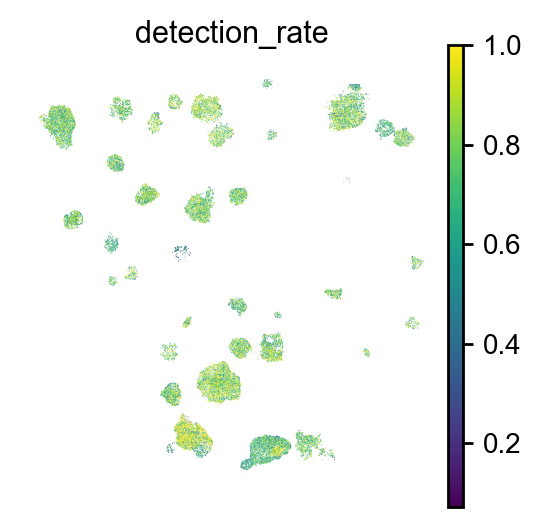

In [208]:
sc.pl.spatial(adata, color = "detection_rate", spot_size = 20,frameon=False)

Edit fraction

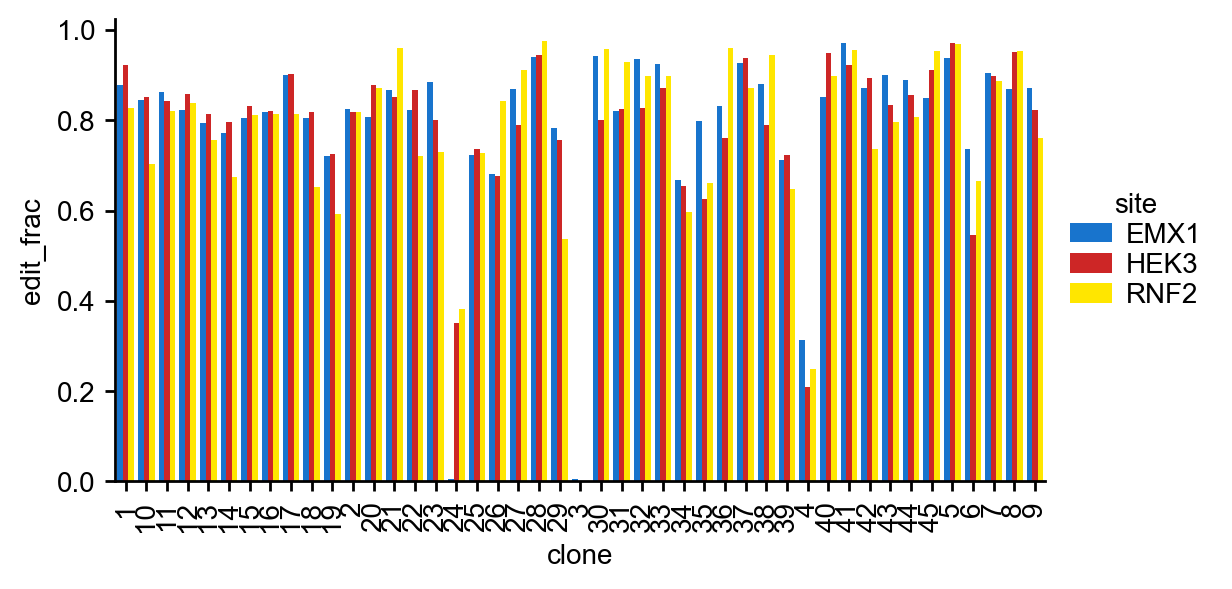

In [209]:
edit_counts = filtered_alleles.query("whitelist")[site_names + ["cellBC","intID","clone","sample"]].melt(
    id_vars = ["cellBC","intID","clone","sample"],value_name="edit", var_name="site")
edit_frac = edit_counts.query("edit != 'None'").groupby(["clone","sample","intID","site"]).size()/ \
    edit_counts.groupby(["clone","sample","intID","site"]).size()
edit_frac = edit_frac.reset_index(name = "edit_frac").groupby(["clone","site"]).agg({"edit_frac":"mean"}).reset_index()
fig, ax = plt.subplots(figsize = (6,3))
sns.barplot(data = edit_frac,y = "edit_frac",x = "clone",hue = "site",saturation=1,ax = ax)
plt.legend(loc='center left', title='site', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90);

Edit frequency

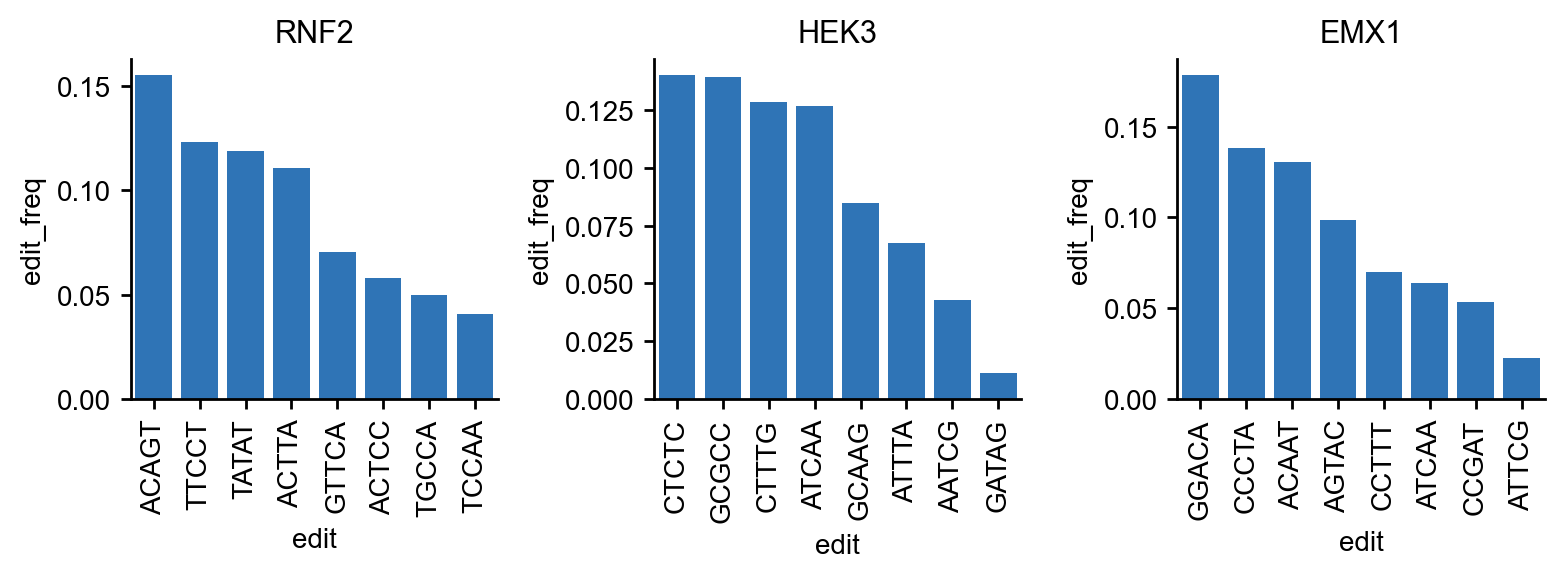

In [210]:
edit_frequency =  edit_counts.groupby(["site","edit"]).size() / edit_counts.groupby(["site"]).size()
edit_frequency = edit_frequency.reset_index(name = "edit_freq")

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, site in enumerate(site_names):
    sns.barplot(
        data=edit_frequency.query(f"site == '{site}' & edit != 'None'").sort_values("edit_freq", ascending=False).head(15),
        x="edit",y="edit_freq", ax=axes[i])
    axes[i].set_title(site)
    plt.setp(axes[i].get_xticklabels(), rotation=90)

plt.tight_layout()

## Cleanup clones

Manually cleanup clone assignments since there are some clones with the same set of integrations

In [418]:
clone_splits = {
    "1":{'node7':"1",
          'node8':"3",
          'node4':"3",
          'node2':"2"},
    "2":{'node15':"1",
         'node45':"2",
         'node5':"3",
         'node6':"4",
         'node28':"5",
         'node46':"5"},
     "4":{'node1':"1",
          'node9':"2",
          'node10':"3"},
     "7":{'node3':"1",
          'node4':"3",
          'node2':"2"},
     "8":{'node1':"1",
          'node2':"2"},
     "10":{'node1':"1",
          'node2':"2"},
     "12":{'node3':"1",
          'node4':"2",
          'node2':"2"},
     "13":{'node57':"1"},
     "14":{'node5':"1",
          'node6':"2",
          'node4':"2"},
     "16":{'node1':"1",
          'node2':"2"},
     "17":{'node1':"1",
          'node2':"2"},
     "21":{'node1':"1"},
     "23":{'node1':"1",
           'node5':"2",
           'node6':"3"},
     "26":{'node1':"1",
           'node2':"2"}}

Reconstruct tree for a specific clone

In [ ]:
def reconstruct_clone(clone):
    characters = alleles_to_characters(filtered_alleles.query("whitelist & clone == @clone"),min_prob=.7)
    clone_tdata = td.TreeData(obs = adata.obs.query("clone == @clone"),allow_overlap = True)
    clone_tdata.obsm["characters"] = characters.loc[clone_tdata.obs_names]
    reconstruct_tree(clone_tdata, solver = "nj",tree_added = "nj",estimate_lengths=False)
    py.pp.add_depth(clone_tdata,tree = "nj")
    return clone_tdata

In [415]:
clone_tdata = reconstruct_clone("16")

Specify clades to split clone into multiple clones

<Axes: >

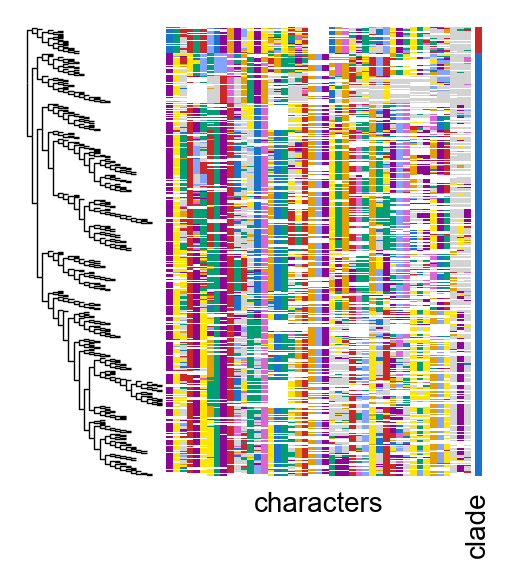

In [416]:
clades = {'node1':"1",'node2':"2"}
py.tl.clades(clone_tdata,tree = "nj",clades = clades)
py.pl.tree(clone_tdata,tree="nj",keys = "characters",cmap = edit_cmap)
py.pl.annotation(clone_tdata,tree = "nj",keys = "clade")

Apply clone splits

In [ ]:
cell_to_clone = {}
for clone in adata.obs["clone"].unique():
    print("Splitting clone ",clone)
    if clone not in clone_splits.keys():
        cell_to_clone.update(adata.obs.query("clone == @clone")["clone"].to_dict())
        continue
    else:
        clone_tdata = reconstruct_clone(clone)
        py.tl.clades(clone_tdata,tree = "nj",clades = clone_splits[clone])
        clades = clone_tdata.obs.query("clade.notna()").copy()
        clades["clade"] = (clone + "-" + clades["clade"])
        cell_to_clone.update(clades["clade"].to_dict())
cell_to_clone = pd.DataFrame.from_dict(cell_to_clone, orient='index', columns=['clone'])
cell_to_clone["cellBC"] = cell_to_clone.index.values

Rename clones by size

In [504]:
clone_counts = cell_to_clone.groupby(["clone"]).size().reset_index(name = "n").sort_values("n",ascending = False)
clone_counts["unique_clone"] = (clone_counts.reset_index().index + 1).astype(str)
cell_to_clone = cell_to_clone.merge(clone_counts[["clone","unique_clone"]], on = ["clone"], how = "left")
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])

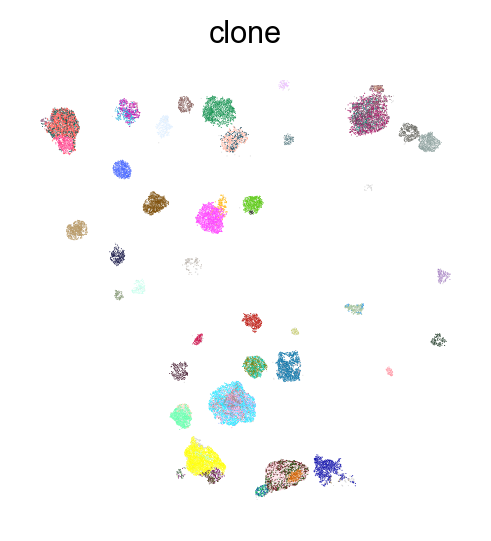

In [505]:
sc.pl.spatial(adata, color = "clone",legend_loc = "none",spot_size=20,legend_fontsize = 6,frameon=False)

Update integration whitelist

In [598]:
min_frac = .4
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])
# Remove integration in less than min_frac cells
for clone in adata.obs["clone"].dropna().unique():
    cell_frac = filtered_alleles.query("clone == @clone").groupby("intID").size() / filtered_alleles.query("clone == @clone").cellBC.nunique()
    clone_ints = cell_frac[cell_frac > .5].index
    filtered_alleles.loc[~filtered_alleles.intID.isin(clone_ints) & (filtered_alleles.clone == clone), "whitelist"] = False

Update detection rate

In [600]:
cell_detection = (filtered_alleles.query("whitelist").groupby(["clone","sample","cellBC"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["intID"].nunique()).reset_index(name = "detection_rate")
adata.obs["detection_rate"] = adata.obs["cellBC"].map(cell_detection.set_index("cellBC")["detection_rate"])

## Reconsctuct trees

In [706]:
def reconstruct_clone(clone):
    clone_tdata = td.TreeData(obs = adata.obs.query("clone == @clone & detection_rate >= .6"),allow_overlap = True)
    characters = alleles_to_characters(filtered_alleles.query("whitelist & cellBC.isin(@clone_tdata.obs_names)"),min_prob=.7)
    clone_tdata.obsm["characters"] = characters.loc[clone_tdata.obs_names]
    reconstruct_tree(clone_tdata, solver = "nj",tree_added = "nj",estimate_lengths=True,collapse_edges = True,mask_truncal=True)
    py.pp.add_depth(clone_tdata,tree = "nj")
    return clone_tdata, clone

Reconstruct trees for all clones

In [707]:
with mp.Pool(processes=16) as pool:
    results = pool.map(reconstruct_clone, adata.obs["clone"].dropna().unique())

/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/cvxpy

Create tdata object with all clones

In [772]:
tdata = td.TreeData(adata.copy(), allow_overlap = False)
tdata.uns["clone_characters"] = {}
characters = []
for clone_tdata, clone in results:
    tdata.obst[clone] = clone_tdata.obst["nj"]
    characters.append(clone_tdata.obsm["characters"]) 
    tdata.uns["clone_characters"][clone] = list(clone_tdata.obsm["characters"].columns.values)
characters = pd.concat(characters)
tdata.obsm["characters"] = characters.reindex(tdata.obs_names).fillna("-1").astype(int) 
tdata.obs.loc[tdata.obs["tree"].isna() & (tdata.obs["type"] == "tracing"), "type"] = "low_detection"

## Write data

In [ ]:
tdata.write(data_path / "colony_tracing.h5ad")

In [ ]:
polygons = []
for sample, path in samples.items():
    sample_polygons = gpd.read_file(path / "polygons_union.json")
    sample_polygons = sample_polygons.set_crs(None, allow_override=True)
    sample_polygons["cellBC"] = (sample + "-" + sample_polygons["cell"].astype(str).values)
    sample_polygons.drop(columns = ["cell"],inplace = True)
    polygons.append(sample_polygons)
polygons = gpd.GeoDataFrame(pd.concat(polygons))
polygons.set_index("cellBC",inplace = True)
polygons.to_file(data_path / "colony_polygons.json", driver='GeoJSON')